# Notebook de entrega a Kaggle, implementación de modelo híbrido regresión lineal + XGBOOST

Primero se va a implementar un modelo en el que no se tiene en cuenta el precio del petróleo, en función de los resultados, se considerará en un segundo modelo. Asimismo, en un primer caso se implementará un dataset X de entrada al modelo de regresión con análisis de la tendencia y transformada de Fourier para captar temporalidad y en el modelo XGBOOST esto ya no se tendrá en cuenta. En función de los resultados, también se introducirá esto en el segundo modelo.

In [1]:
# Setup notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import warnings
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from joblib import Parallel, delayed
import category_encoders as ce
from matplotlib.offsetbox import AnchoredText
import math
from sklearn.preprocessing import LabelEncoder

Importación de los archivos

In [2]:
store_sales_train = pd.read_csv('train.csv')
store_sales_test = pd.read_csv('test.csv')
oil = pd.read_csv('oil.csv', parse_dates=['date'])
holidays_events = pd.read_csv('holidays_events.csv', dtype={'type': 'category','locale': 'category',
                            'locale_name': 'category','description': 'category','transferred': 'bool',}, parse_dates=['date'], infer_datetime_format=True)
transactions = pd.read_csv('transactions.csv', parse_dates=['date'])
stores = pd.read_csv('stores.csv')

Se pasa la fecha a periodo para crear el dataset X  y se utilizarán únicamente los datos de 2017 para ajustar el modelo

In [3]:
store_sales_train['date'] = pd.to_datetime(store_sales_train['date'])
store_sales_train['date'] = store_sales_train.date.dt.to_period('D')
store_sales_test['date'] = pd.to_datetime(store_sales_test['date'])
store_sales_test['date'] = store_sales_test.date.dt.to_period('D')

store_sales_train_17 = store_sales_train.loc[store_sales_train['date']>='2017-01-02'].set_index(['store_nbr', 'family', 'date']).sort_index()

In [4]:
y_train_LR = store_sales_train_17.unstack(['store_nbr', 'family'])
y_train_LR = y_train_LR['sales']

fourier = CalendarFourier(freq="M", order=4)
dp = DeterministicProcess(
    index=y_train_LR.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)
X1_train_LR = dp.in_sample()

In [5]:
holidays_events = holidays_events.set_index('date').to_period('D')

holidays_17 = (
    holidays_events
    .query("locale in ['National']")
    .loc['2017':'2017-08-31', ['type','transferred']]
)

holidays_17.drop(holidays_17[holidays_17['transferred']==True].index,axis=0,inplace=True)
holidays_17.rename(columns = {'type':'event_type'}, inplace=True)

holidays_17.loc[holidays_17['event_type'].isin(['Holiday','Transfer','Additional', 'Bridge']),'Free_day']=1
holidays_17.loc[holidays_17['event_type'].isin(['Event']),'Event']=1
holidays_17['Free_day'].fillna(0,inplace=True)
holidays_17['Event'].fillna(0,inplace=True)

display(holidays_17)

,event_type,transferred,Free_day,Event
date,,,,
2017-01-02,Transfer,False,1.0,0.0
2017-02-27,Holiday,False,1.0,0.0
2017-02-28,Holiday,False,1.0,0.0
2017-04-14,Holiday,False,1.0,0.0
2017-05-01,Holiday,False,1.0,0.0
2017-05-13,Additional,False,1.0,0.0
2017-05-14,Event,False,0.0,1.0
2017-05-26,Transfer,False,1.0,0.0
2017-08-11,Transfer,False,1.0,0.0


In [6]:
X2_train_LR = X1_train_LR.join(holidays_17[['Free_day','Event']], on='date').fillna(0.0)

model_LR =Ridge(fit_intercept=False).fit(X2_train_LR, y_train_LR)
y_pred_LR = pd.DataFrame(model_LR.predict(X2_train_LR), index=y_train_LR.index, columns=y_train_LR.columns)

In [7]:
X_test_LR = dp.out_of_sample(steps=16)
X_test_LR.index.names=['date']
X_test_LR = X_test_LR.join(holidays_17[['Free_day','Event']], on='date').fillna(0.0)

y_fore_LR = pd.DataFrame(model_LR.predict(X_test_LR), index= X_test_LR.index, columns=y_train_LR.columns)

In [8]:
residuos_LR = y_train_LR-y_pred_LR
residuos_LR = pd.DataFrame(residuos_LR.stack(['store_nbr', 'family']))
residuos_LR.reset_index(inplace=True)

In [9]:
familias = list(store_sales_train.family.unique())

In [10]:
imp_lags = {'AUTOMOTIVE': [4,6,7],
'BABY CARE':[2],
'BEAUTY': [1,2,3],
'BEVERAGES':[7],
'BOOKS':[1,4,5],
'BREAD/BAKERY':[2,7],
'CLEANING':[1],
'DAIRY':[2,7],
'DELI':[2,7],
'EGGS': [2,7],
'FROZEN FOODS': [1],
'GROCERY I':[2],
'GROCERY II':[1,5],
'HARDWARE': [5,6],
'HOME AND KITCHEN I':[1,2],
'HOME AND KITCHEN II':[1,2,3],
'HOME APPLIANCES':[1,2,3,5,6],
'HOME CARE':[5,7],
'LADIESWEAR':[2,7],
'LAWN AND GARDEN':[1,2],
'LINGERIE':[1,2,5],
'LIQUOR,WINE,BEER':[1,2,6],
'MAGAZINES':[1,6],
'MEATS':[5],
'PLAYERS AND ELECTRONICS':[7],
'POULTRY':[5],
'PREPARED FOODS':[1,7],
'PRODUCE':[2],
'SCHOOL AND OFFICE SUPPLIES':[1,4,5,7],
'SEAFOOD':[1,3,5]}

In [12]:
promotions_train = pd.DataFrame(store_sales_train_17['onpromotion'])
promotions_train.reset_index(inplace=True)
promotions_test = pd.DataFrame(store_sales_test[['onpromotion','date','store_nbr','family']])

In [13]:
residuos_LR.rename(columns={0:'residuos'},inplace=True)
residuos_LR['date'] = residuos_LR['date'].dt.to_timestamp()
promotions_train['date'] = promotions_train['date'].dt.to_timestamp()
residuos_LR_train = residuos_LR.merge(promotions_train, on=['date' ,'store_nbr','family'],how='left').fillna(0.0)
residuos_LR_train = residuos_LR_train.merge(stores, on=['store_nbr'],how='left').fillna(0.0)

residuos_LR_test = promotions_test.merge(stores, on=['store_nbr'],how='left').fillna(0.0)

In [15]:
holidays_17_reg = (
    holidays_events
    .query("locale in ['Regional']")
    .loc['2017':'2017-08-31', ['type','locale_name','transferred']]
)

holidays_17_loc = (
    holidays_events
    .query("locale in ['Local']")
    .loc['2017':'2017-08-31', ['type','locale_name','transferred']]
)

holidays_17_reg.drop(holidays_17_reg[holidays_17_reg['transferred']==True].index,axis=0,inplace=True)
holidays_17_loc.drop(holidays_17_loc[holidays_17_loc['transferred']==True].index,axis=0,inplace=True)

holidays_17_reg.rename(columns = {'type':'event_type'}, inplace=True)
holidays_17_loc.rename(columns = {'type':'event_type'}, inplace=True)

holidays_17_reg.loc[holidays_17_reg['event_type'].isin(['Holiday','Transfer','Additional', 'Bridge']),'Free_day']=1
holidays_17_loc.loc[holidays_17_loc['event_type'].isin(['Holiday','Transfer','Additional', 'Bridge']),'Free_day']=1

#No hay eventos locales ni regionales
#holidays_17_reg.loc[holidays_17_reg['event_type'].isin(['Event']),'Event']=1
#holidays_17_loc.loc[holidays_17_loc['event_type'].isin(['Event']),'Event']=1

#holidays_17_reg['Event'].fillna(0,inplace=True)
#holidays_17_loc['Event'].fillna(0,inplace=True)

holidays_17_reg['Free_day'].fillna(0,inplace=True)
holidays_17_loc['Free_day'].fillna(0,inplace=True)

holidays_17_reg.drop(['event_type','transferred'],axis=1,inplace=True)
holidays_17_loc.drop(['event_type','transferred'],axis=1,inplace=True)

holidays_17_reg['locale_name']=holidays_17_reg['locale_name'].astype('object')
holidays_17_loc['locale_name']=holidays_17_loc['locale_name'].astype('object')

In [16]:
residuos_LR_train = residuos_LR_train.merge(holidays_17_reg, left_on=['date','state'], right_on=['date','locale_name'], how='left').fillna(0.0)
residuos_LR_train = residuos_LR_train.merge(holidays_17_loc, left_on=['date','city'], right_on=['date','locale_name'],how='left').fillna(0.0)

residuos_LR_test = residuos_LR_test.merge(holidays_17_reg, left_on=['date','state'], right_on=['date','locale_name'], how='left').fillna(0.0)
residuos_LR_test = residuos_LR_test.merge(holidays_17_loc, left_on=['date','city'], right_on=['date','locale_name'],how='left').fillna(0.0)


residuos_LR_train['Free_day'] = residuos_LR_train['Free_day_x'] + residuos_LR_train['Free_day_y']
residuos_LR_train.drop(['city','state','locale_name_x','Free_day_x','locale_name_y','Free_day_y'], axis=1, inplace=True)

residuos_LR_test['Free_day'] = residuos_LR_test['Free_day_x'] + residuos_LR_test['Free_day_y']
residuos_LR_test.drop(['city','state','locale_name_x','Free_day_x','locale_name_y','Free_day_y'], axis=1, inplace=True)

In [17]:
residuos_LR_test['residuos']=np.nan

In [18]:
ohencoder = ce.OneHotEncoder(cols='type', use_cat_names=True)

residuos_LR_train = ohencoder.fit_transform(residuos_LR_train)
residuos_LR_test = ohencoder.transform(residuos_LR_test)


residuos_LR_train['date'] = pd.to_datetime(residuos_LR_train['date'])
residuos_LR_train['date'] = residuos_LR_train.date.dt.to_period('D')

residuos_LR_train.set_index('date',inplace=True)
residuos_LR_train['dayofweek'] = residuos_LR_train.index.dayofweek
residuos_LR_train['dayofmonth'] = residuos_LR_train.index.day

residuos_LR_test.set_index('date',inplace=True)
residuos_LR_test['dayofweek'] = residuos_LR_test.index.dayofweek
residuos_LR_test['dayofmonth'] = residuos_LR_test.index.day

In [18]:
residuos_LR = pd.concat([residuos_LR_train,residuos_LR_test])

In [19]:
def make_lags_residuos(ts, lags):
    return pd.concat(
        {
            f'y_lag_residuos_{i}': ts.shift(i)
            for i in lags
        },
        axis=1)

def make_lags_promotions(ts, lags):
    return pd.concat(
        {
            f'y_lag_promotions_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

def make_leads_promotions(ts, leads):
    return pd.concat(
        {
            f'y_lead_promotions_{i}': ts.shift(-i)
            for i in range(1, leads + 1)
        },
        axis=1)

In [20]:
residuos_dict = {}

for familia in familias:
    residuos_dict[familia] = pd.DataFrame(residuos_LR[residuos_LR['family']==familia].reset_index())
    residuos_dict[familia]['tienda'] = residuos_dict[familia]['store_nbr']
    residuos_dict[familia] = residuos_dict[familia].drop('family', axis=1)
    residuos_dict[familia] = residuos_dict[familia].set_index(['store_nbr', 'date']).sort_index()

lags_promo_dict = {}
leads_promo_dict = {}
for familia in familias:
    lags_promo_dict[familia]=make_lags_promotions(residuos_dict[familia].onpromotion, lags = 3)
    leads_promo_dict[familia]=make_leads_promotions(residuos_dict[familia].onpromotion, leads = 3)
    residuos_dict[familia] = residuos_dict[familia].join(lags_promo_dict[familia])
    residuos_dict[familia] = residuos_dict[familia].join(leads_promo_dict[familia])

In [21]:
lags_resi_dict = {}
for familia in imp_lags.keys():
    lags_resi_dict[familia]=make_lags_residuos(residuos_dict[familia].residuos, lags = imp_lags[familia])
    residuos_dict[familia] = residuos_dict[familia].join(lags_resi_dict[familia])

Va a volver a dividirse en entrenamiento y test el dataset de residuos que se tiene para cada familia y al dataset de entrenamiento se le van a quitar las 8 primeras fechas, pues son las que podrían contener nans y por parte del set de validación, las leads de promociones se van a poner a 0 en las tres últimas fechas

In [22]:
store_sales_test['date'].unique()

<PeriodArray>
['2017-08-16', '2017-08-17', '2017-08-18', '2017-08-19', '2017-08-20',
 '2017-08-21', '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
 '2017-08-26', '2017-08-27', '2017-08-28', '2017-08-29', '2017-08-30',
 '2017-08-31']
Length: 16, dtype: period[D]

In [23]:
residuos_train_dict = {}
residuos_test_dict = {}
for familia in familias:
    residuos_dict[familia].reset_index(inplace=True)
    residuos_train_dict[familia] = residuos_dict[familia].loc[(residuos_dict[familia]['date']>'2017-01-08') & (residuos_dict[familia]['date']<'2017-08-16')]
    residuos_test_dict[familia] = residuos_dict[familia].loc[residuos_dict[familia]['date']>='2017-08-16']
    residuos_test_dict[familia].set_index('date',inplace=True)
    residuos_test_dict[familia].loc['2017-08-31','y_lead_promotions_1':'y_lead_promotions_3'] = 0
    residuos_test_dict[familia].loc['2017-08-30','y_lead_promotions_2':'y_lead_promotions_3'] = 0
    residuos_test_dict[familia].loc['2017-08-29','y_lead_promotions_3'] = 0
    residuos_train_dict[familia] = residuos_train_dict[familia].set_index(['store_nbr','date']).sort_index()
    residuos_test_dict[familia].reset_index(inplace=True)
    residuos_test_dict[familia] = residuos_test_dict[familia].set_index(['store_nbr','date']).sort_index()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [ ]:
X_train_dict = {}
y_train_dict ={}

for familia in familias:
    X_train_dict[familia] = residuos_train_dict[familia].drop('residuos',axis=1)
    y_train_dict[familia] = pd.DataFrame(residuos_train_dict[familia]['residuos'])

In [26]:
dict_params = {"n_estimators": [100, 150],
               "max_depth": [5, 8, 11],
               "learning_rate": [0.06, 0.02, 0.1],
               "objective": ["reg:squarederror"],
               "tree_method": ["hist"],
               "subsample": [0.6,1]
              }

In [27]:
modelos_dict_XGB1 = {}
y_pred_dict_XGB1 = {}

for familia in familias:
    modelos_dict_XGB1[familia] = GridSearchCV(estimator=XGBRegressor(random_state=50),
                         param_grid=dict_params,
                         refit=True,
                         verbose=1,
                         n_jobs=-1,
                         return_train_score=True,
                         scoring="neg_mean_squared_error"
                         )

In [28]:
for familia in familias:
    modelos_dict_XGB1[familia].fit(X_train_dict[familia], y_train_dict[familia])
    print(f'Ajustado modelo de {familia} \n {modelos_dict_XGB1[familia].best_params_}')
    y_pred_dict_XGB1[familia] =pd.DataFrame(modelos_dict_XGB1[familia].predict(X_train_dict[familia]), index=y_train_dict[familia].index, columns=y_train_dict[familia].columns)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Ajustado modelo de AUTOMOTIVE 
 {'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.6, 'tree_method': 'hist'}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Ajustado modelo de BABY CARE 
 {'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.6, 'tree_method': 'hist'}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Ajustado modelo de BEAUTY 
 {'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 150, 'objective': 'reg:squarederror', 'subsample': 0.6, 'tree_method': 'hist'}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Ajustado modelo de BEVERAGES 
 {'learning_rate': 0.02, 'max_depth': 11, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.6, 'tree_method': 'hist'}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Ajustado modelo de BOOKS 
 

Bucle para ir actualizando los valores de test

In [33]:
X1_test_dict = {}
resul_actual = {}

for familia in familias:
    X1_test_dict[familia] = residuos_test_dict[familia].loc[:,'onpromotion':'y_lead_promotions_3']
    X1_test_dict[familia] = X1_test_dict[familia].reset_index()
    resul_actual[familia] = pd.concat([y_train_dict[familia].reset_index(),X1_test_dict[familia].reset_index()[['date','store_nbr']]]).set_index(['store_nbr','date']).sort_index()

In [35]:
fechas = pd.date_range(start="2017-08-16", end = "2017-08-31").to_period(freq='D').tolist()
lags_resi_test={}
X2_iteracion = {}
X1_iteracion = {}
X_iteracion = {}
pred_iter = {}

for fecha in fechas:
    for familia in familias:
        X1_iteracion[familia] = X1_test_dict[familia][X1_test_dict[familia]['date']==fecha]
        X1_iteracion[familia] = X1_iteracion[familia].set_index(['store_nbr','date']).sort_index()
        if familia in imp_lags.keys():
            lags_resi_test[familia] = make_lags_residuos(resul_actual[familia].residuos, lags = imp_lags[familia])
            lags_resi_test[familia].reset_index(inplace=True)
            X2_iteracion[familia] = lags_resi_test[familia][lags_resi_test[familia]['date']==fecha]
            X2_iteracion[familia] = X2_iteracion[familia].set_index(['store_nbr','date']).sort_index()
            X_iteracion[familia] = X1_iteracion[familia].join(X2_iteracion[familia])
        else:
            X_iteracion[familia] = X1_iteracion[familia]
        pred_iter[familia] = pd.DataFrame(modelos_dict_XGB1[familia].predict(X_iteracion[familia]), index=X_iteracion[familia].index, columns = y_train_dict[familia].columns)
        resul_actual[familia] = resul_actual[familia].reset_index()
        resul_actual[familia] = resul_actual[familia][resul_actual[familia]['date'] != fecha]
        resul_actual[familia] = resul_actual[familia].set_index(['store_nbr', 'date']).sort_index()
        resul_actual[familia] = pd.concat([resul_actual[familia],pred_iter[familia]]).sort_index()    

In [36]:
y_fore_dict = {}

for familia in familias:
    y_fore_dict[familia] = resul_actual[familia].reset_index()
    y_fore_dict[familia] = y_fore_dict[familia][y_fore_dict[familia]['date']>='2017-08-16'].set_index(['store_nbr','date']).sort_index()

In [37]:
residuos_ajustados_test = pd.DataFrame()
for familia in familias:
    y_fore_dict[familia]['family']=familia
    residuos_ajustados_test = pd.concat([residuos_ajustados_test, y_fore_dict[familia]])

Se procede a sumar las predicciones iniciales y estos valores de los residuos para obtener las predicciones finales de ventas

In [46]:
residuos_ajustados_test = residuos_ajustados_test.reset_index().set_index(['store_nbr', 'family', 'date']).sort_index().rename(columns={0:'predicted_residuos'})
y_fore_LR = y_fore_LR.stack(['store_nbr','family']).reset_index().set_index(['store_nbr', 'family', 'date']).sort_index().rename(columns={0:'predicted_sales'})
y_test_pred = pd.DataFrame()
y_test_pred['adjusted_predicted_sales'] = y_fore_LR['predicted_sales'] + residuos_ajustados_test['residuos']
y_test_pred.loc[y_test_pred['adjusted_predicted_sales']<0,'adjusted_predicted_sales'] = 0
y_test_pred

adjusted_predicted_sales
store_nbr family     date                                
1         AUTOMOTIVE 2017-08-16                  4.230201
                     2017-08-17                  4.058839
                     2017-08-18                  5.329279
                     2017-08-19                  4.306507
                     2017-08-20                  2.312142
...                                                   ...
54        SEAFOOD    2017-08-27                  3.436212
                     2017-08-28                  3.186863
                     2017-08-29                  3.724454
                     2017-08-30                  4.597391
                     2017-08-31                  3.439564

[28512 rows x 1 columns]

In [48]:
store_sales_test = store_sales_test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [50]:
y_submit = y_test_pred.join(store_sales_test.id)
y_submit.columns = ['sales','id']
y_submit = y_submit.set_index('id')
y_submit.sort_index(inplace=True)
y_submit

,sales
id,
3000888,4.230201
3000889,0.062689
3000890,4.655790
3000891,2365.156885
3000892,0.388164
...,...
3029395,373.688203
3029396,108.169611
3029397,1277.433202


In [52]:
y_submit.to_csv('submission5.csv')

**El RMSLE obtenido en esta entrega ha empeorado hasta 0.65308, por lo que claramente los residuos no se han ajustado de forma correcta**
Se observa abajo el error cuadrático medio para los residuos para cada familia y hay alguna de ellas para las que el valor ex muy elevado

In [55]:
for familia in familias:
    print(f'El error cuadrático medio en train es {mean_squared_error(y_train_dict[familia], y_pred_dict_XGB1[familia])}')

El error cuadrático medio en train es 12.29060552586639
El error cuadrático medio en train es 0.29845981589844695
El error cuadrático medio en train es 7.417281830036537
El error cuadrático medio en train es 233703.70941328246
El error cuadrático medio en train es 0.1622774000372116
El error cuadrático medio en train es 4062.767989758089
El error cuadrático medio en train es 74.44495257467153
El error cuadrático medio en train es 114295.69838697734
El error cuadrático medio en train es 4474.195814324856
El error cuadrático medio en train es 1683.017720561055
El error cuadrático medio en train es 1385.7893362954721
El error cuadrático medio en train es 1136.8350074373116
El error cuadrático medio en train es 301274.4779181231
El error cuadrático medio en train es 139.5633050300459
El error cuadrático medio en train es 1.927685483429065
El error cuadrático medio en train es 404.3722260907932
El error cuadrático medio en train es 294.76394839725896
El error cuadrático medio en train es 0.

# Nuevo modelo para ajustar los residuos

Se parte de los residuos de la predicción reañizada con Ridge para implementar este nuevo modelo

In [30]:
residuos_LR = y_train_LR-y_pred_LR
residuos_LR = pd.DataFrame(residuos_LR.stack(['store_nbr', 'family']))
residuos_LR.reset_index(inplace=True)

promotions_train = pd.DataFrame(store_sales_train_17['onpromotion'])
promotions_train.reset_index(inplace=True)
promotions_test = pd.DataFrame(store_sales_test[['onpromotion','date','store_nbr','family']])

residuos_LR.rename(columns={0:'residuos'},inplace=True)
residuos_LR['date'] = residuos_LR['date'].dt.to_timestamp()
promotions_train['date'] = promotions_train['date'].dt.to_timestamp()
residuos_LR_train = residuos_LR.merge(promotions_train, on=['date' ,'store_nbr','family'],how='left').fillna(0.0)
residuos_LR_train = residuos_LR_train.merge(stores, on=['store_nbr'],how='left').fillna(0.0)

residuos_LR_test = promotions_test.merge(stores, on=['store_nbr'],how='left').fillna(0.0)

holidays_17_reg = (
    holidays_events
    .query("locale in ['Regional']")
    .loc['2017':'2017-08-31', ['type','locale_name','transferred']]
)

holidays_17_loc = (
    holidays_events
    .query("locale in ['Local']")
    .loc['2017':'2017-08-31', ['type','locale_name','transferred']]
)

holidays_17_reg.drop(holidays_17_reg[holidays_17_reg['transferred']==True].index,axis=0,inplace=True)
holidays_17_loc.drop(holidays_17_loc[holidays_17_loc['transferred']==True].index,axis=0,inplace=True)

holidays_17_reg.rename(columns = {'type':'event_type'}, inplace=True)
holidays_17_loc.rename(columns = {'type':'event_type'}, inplace=True)

holidays_17_reg.loc[holidays_17_reg['event_type'].isin(['Holiday','Transfer','Additional', 'Bridge']),'Free_day']=1
holidays_17_loc.loc[holidays_17_loc['event_type'].isin(['Holiday','Transfer','Additional', 'Bridge']),'Free_day']=1

#No hay eventos locales ni regionales
#holidays_17_reg.loc[holidays_17_reg['event_type'].isin(['Event']),'Event']=1
#holidays_17_loc.loc[holidays_17_loc['event_type'].isin(['Event']),'Event']=1

#holidays_17_reg['Event'].fillna(0,inplace=True)
#holidays_17_loc['Event'].fillna(0,inplace=True)

holidays_17_reg['Free_day'].fillna(0,inplace=True)
holidays_17_loc['Free_day'].fillna(0,inplace=True)

holidays_17_reg.drop(['event_type','transferred'],axis=1,inplace=True)
holidays_17_loc.drop(['event_type','transferred'],axis=1,inplace=True)

holidays_17_reg['locale_name']=holidays_17_reg['locale_name'].astype('object')
holidays_17_loc['locale_name']=holidays_17_loc['locale_name'].astype('object')


residuos_LR_train = residuos_LR_train.merge(holidays_17_reg, left_on=['date','state'], right_on=['date','locale_name'], how='left').fillna(0.0)
residuos_LR_train = residuos_LR_train.merge(holidays_17_loc, left_on=['date','city'], right_on=['date','locale_name'],how='left').fillna(0.0)

residuos_LR_test = residuos_LR_test.merge(holidays_17_reg, left_on=['date','state'], right_on=['date','locale_name'], how='left').fillna(0.0)
residuos_LR_test = residuos_LR_test.merge(holidays_17_loc, left_on=['date','city'], right_on=['date','locale_name'],how='left').fillna(0.0)


residuos_LR_train['Free_day'] = residuos_LR_train['Free_day_x'] + residuos_LR_train['Free_day_y']
residuos_LR_train.drop(['city','state','locale_name_x','Free_day_x','locale_name_y','Free_day_y'], axis=1, inplace=True)

residuos_LR_test['Free_day'] = residuos_LR_test['Free_day_x'] + residuos_LR_test['Free_day_y']
residuos_LR_test.drop(['city','state','locale_name_x','Free_day_x','locale_name_y','Free_day_y'], axis=1, inplace=True)

residuos_LR_test['residuos']=np.nan


ohencoder = ce.OneHotEncoder(cols='type', use_cat_names=True)

residuos_LR_train = ohencoder.fit_transform(residuos_LR_train)
residuos_LR_test = ohencoder.transform(residuos_LR_test)


residuos_LR_train['date'] = pd.to_datetime(residuos_LR_train['date'])
residuos_LR_train['date'] = residuos_LR_train.date.dt.to_period('D')

residuos_LR_train.set_index('date',inplace=True)
residuos_LR_train['dayofweek'] = residuos_LR_train.index.dayofweek
residuos_LR_train['dayofmonth'] = residuos_LR_train.index.day

residuos_LR_test.set_index('date',inplace=True)
residuos_LR_test['dayofweek'] = residuos_LR_test.index.dayofweek
residuos_LR_test['dayofmonth'] = residuos_LR_test.index.day

In [12]:
residuos_LR_train

,store_nbr,family,residuos,onpromotion,type_D,type_B,type_C,type_E,type_A,cluster,Free_day,dayofweek,dayofmonth
date,,,,,,,,,,,,,
2017-01-02,1,AUTOMOTIVE,3.323478,0,1,0,0,0,0,13,0.0,0,2
2017-01-02,1,BABY CARE,0.000000,0,1,0,0,0,0,13,0.0,0,2
2017-01-02,1,BEAUTY,-2.366353,0,1,0,0,0,0,13,0.0,0,2
2017-01-02,1,BEVERAGES,20.523578,31,1,0,0,0,0,13,0.0,0,2
2017-01-02,1,BOOKS,-0.267723,0,1,0,0,0,0,13,0.0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-15,54,POULTRY,-12.166820,0,0,0,1,0,0,3,0.0,1,15
2017-08-15,54,PREPARED FOODS,3.989036,0,0,0,1,0,0,3,0.0,1,15
2017-08-15,54,PRODUCE,-24.258599,76,0,0,1,0,0,3,0.0,1,15


In [13]:
residuos_LR_test

,onpromotion,store_nbr,family,type_D,type_B,type_C,type_E,type_A,cluster,Free_day,residuos,dayofweek,dayofmonth
date,,,,,,,,,,,,,
2017-08-16,0,1,AUTOMOTIVE,1,0,0,0,0,13,0.0,NaN,2,16
2017-08-16,0,1,BABY CARE,1,0,0,0,0,13,0.0,NaN,2,16
2017-08-16,2,1,BEAUTY,1,0,0,0,0,13,0.0,NaN,2,16
2017-08-16,20,1,BEVERAGES,1,0,0,0,0,13,0.0,NaN,2,16
2017-08-16,0,1,BOOKS,1,0,0,0,0,13,0.0,NaN,2,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,1,9,POULTRY,0,1,0,0,0,6,0.0,NaN,3,31
2017-08-31,0,9,PREPARED FOODS,0,1,0,0,0,6,0.0,NaN,3,31
2017-08-31,1,9,PRODUCE,0,1,0,0,0,6,0.0,NaN,3,31


Se va a analizar la temporalidad de los residuos, de cara a implementar en el dataset de variables predictoras del modelo XGBoost un DeterministicProcess con componentes de Fourier

In [31]:
from scipy.signal import periodogram
def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(ts, fs=fs, detrend=detrend, window="boxcar", scaling='spectrum')
    
    if ax is None:
        fig = plt.figure(figsize = (25,5))
        ax = fig.add_subplot()
    
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(["Annual (1)", "Semiannual (2)", "Quarterly (4)", 
                        "Bimonthly (6)", "Monthly (12)", "Biweekly (26)", 
                        "Weekly (52)", "Semiweekly (104)"], rotation=30)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    
    return ax

<ipython-input-25-c00e887b456c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize = (25,5))


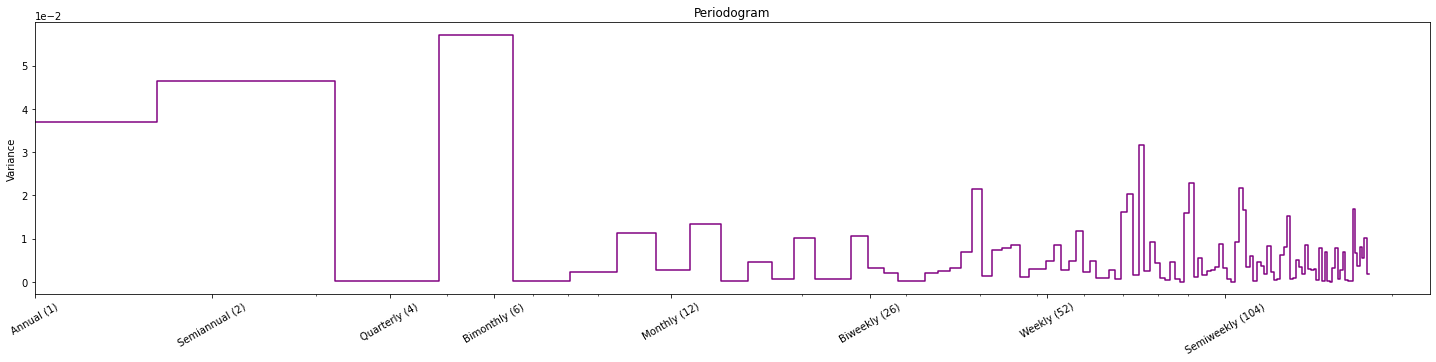

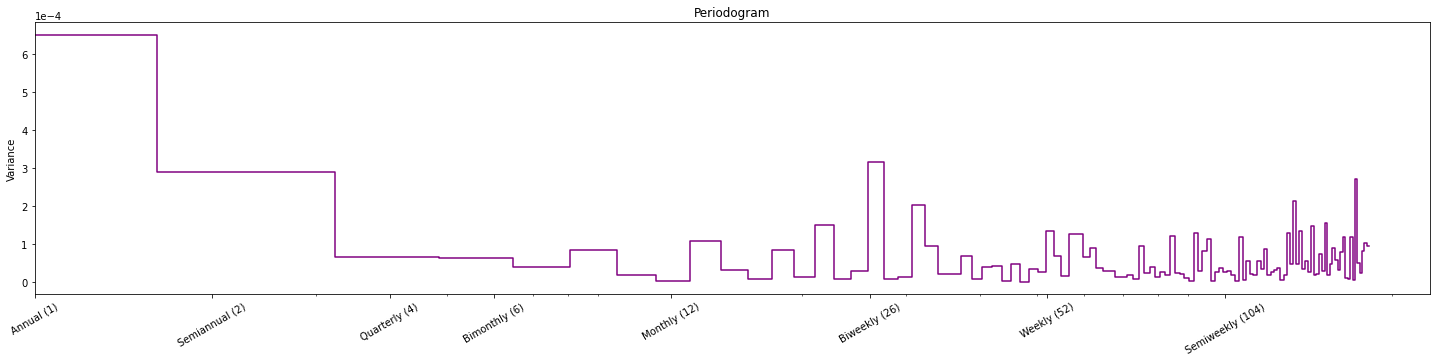

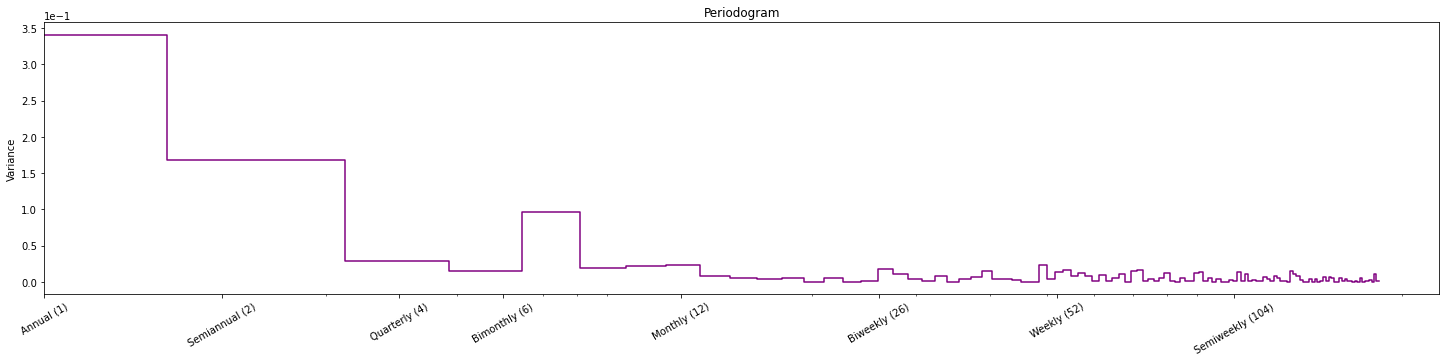

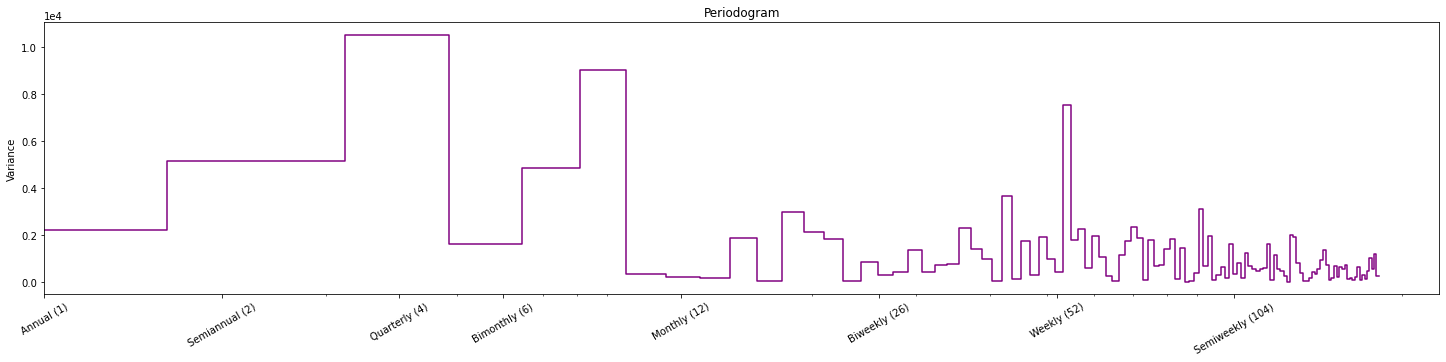

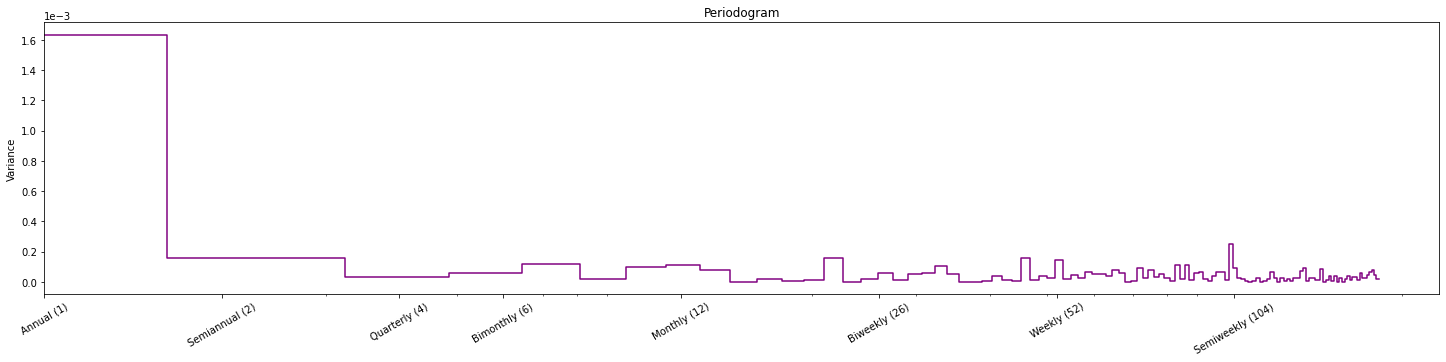

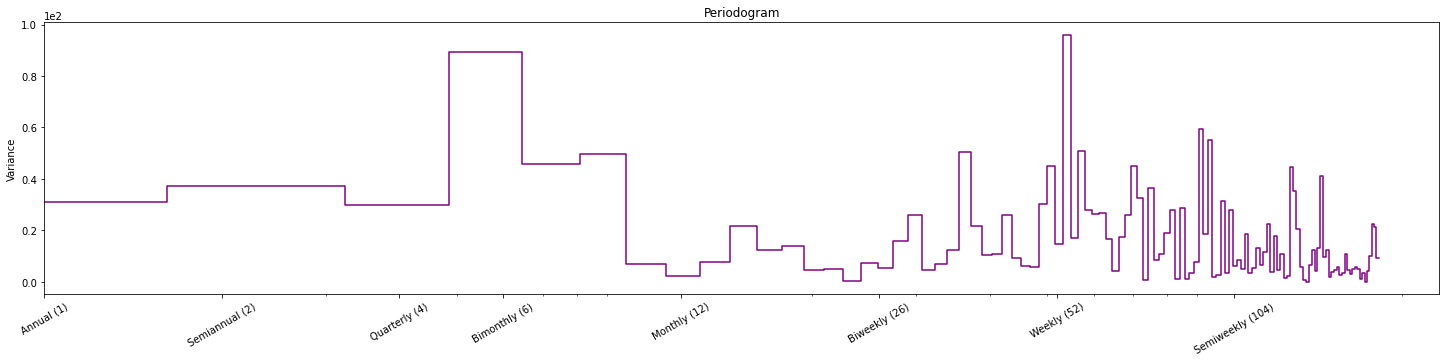

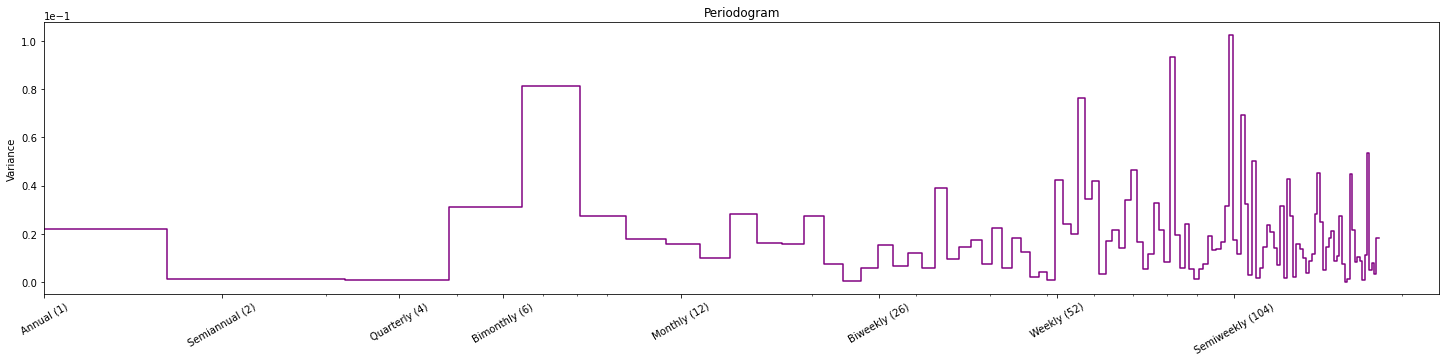

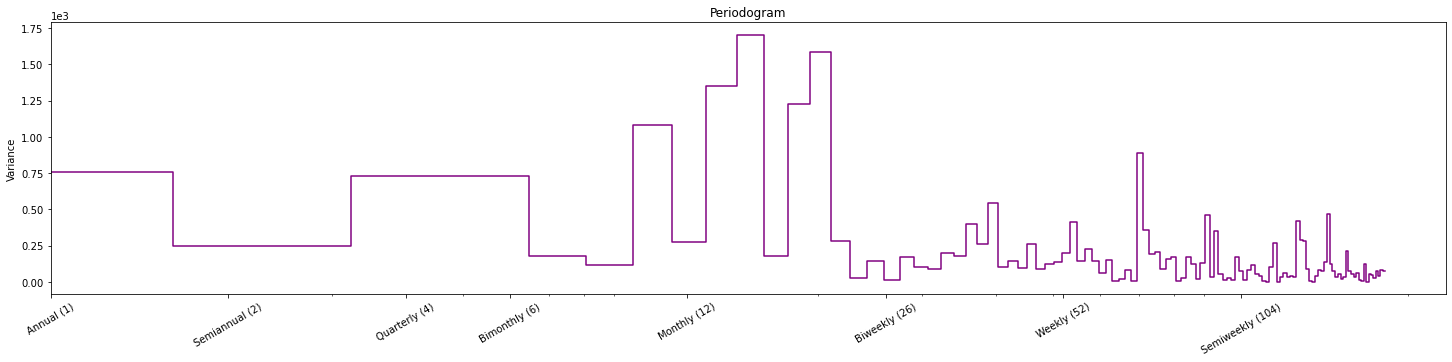

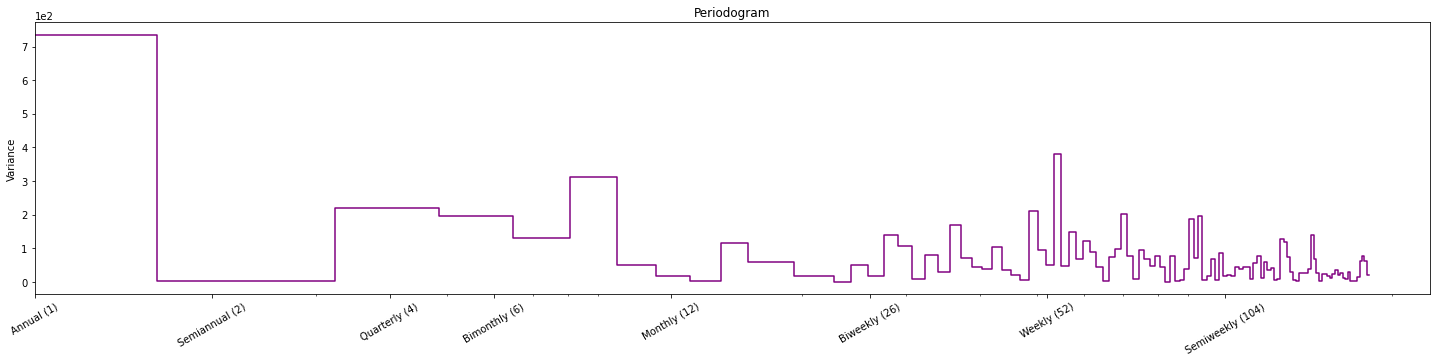

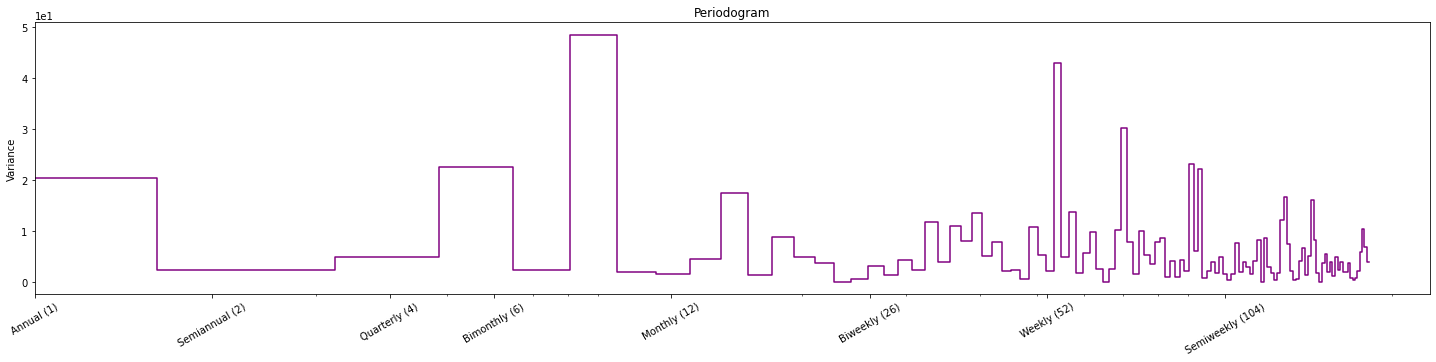

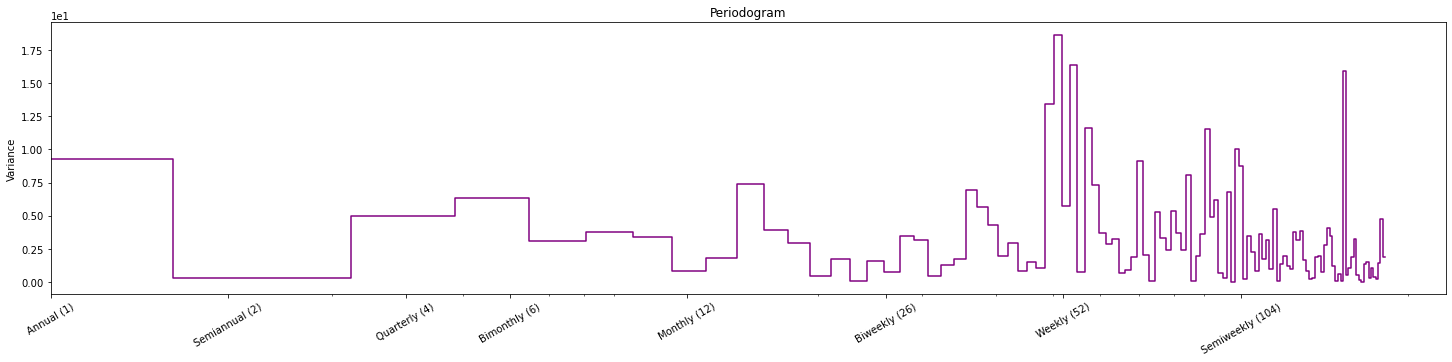

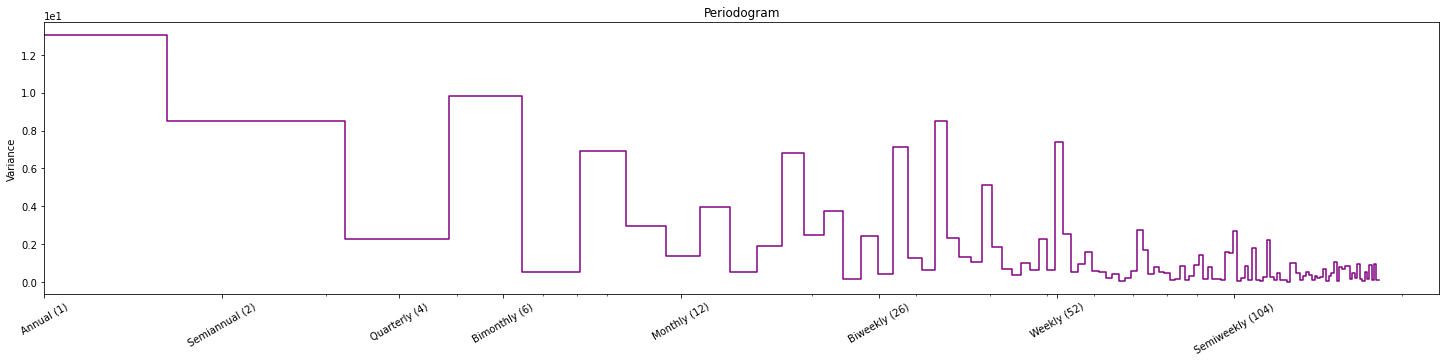

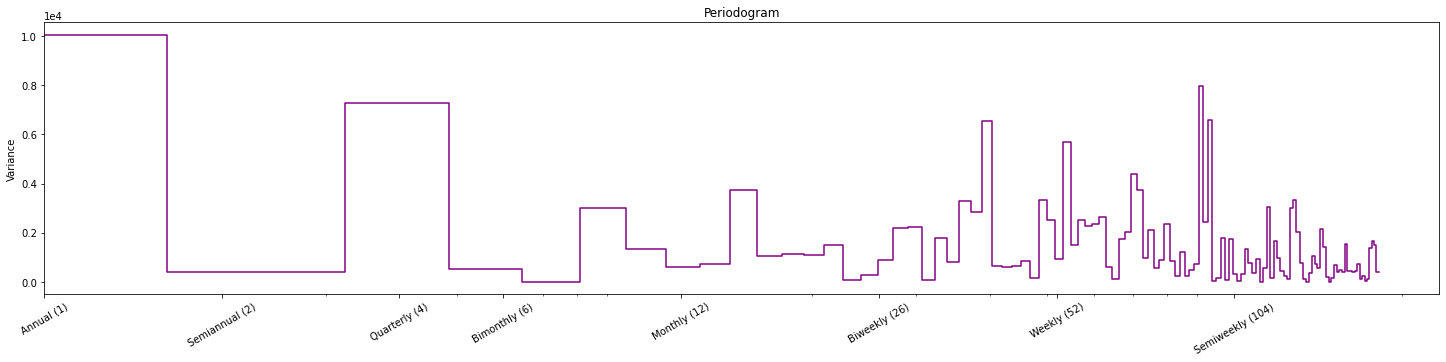

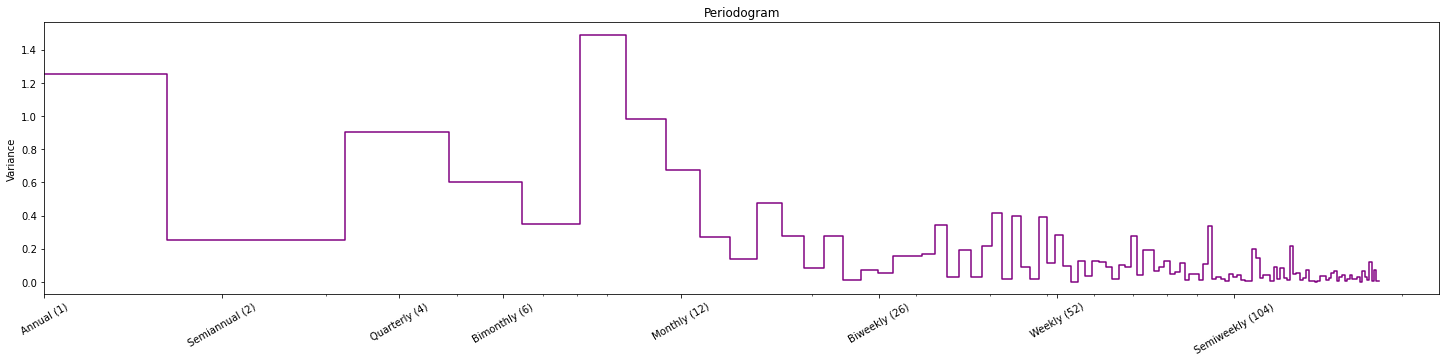

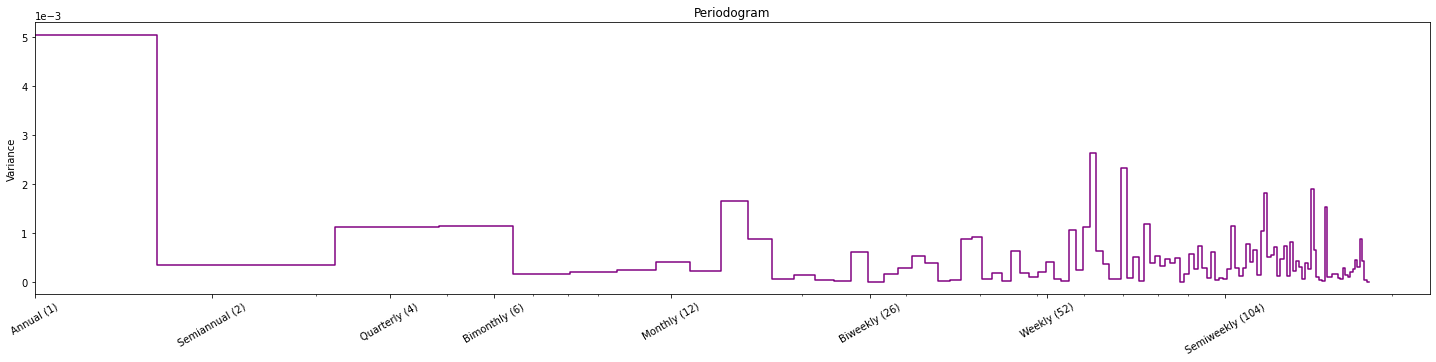

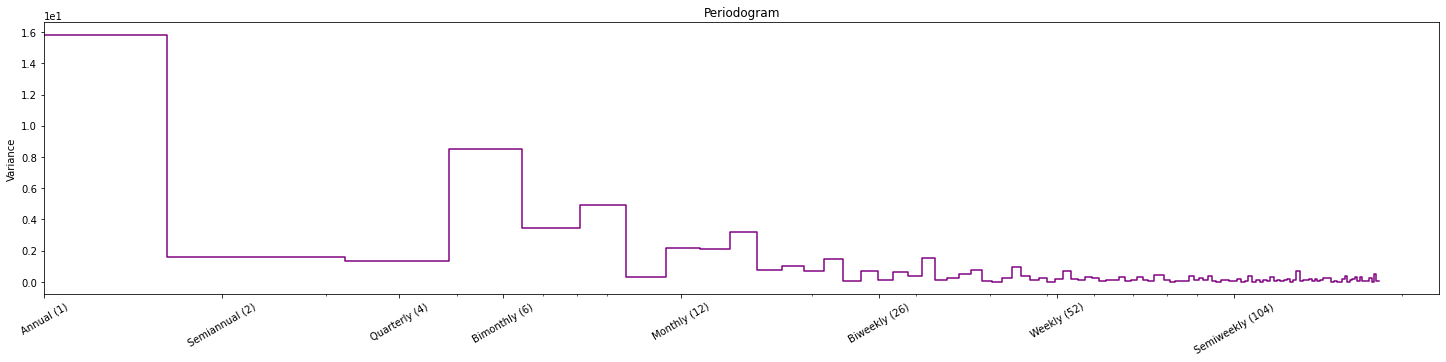

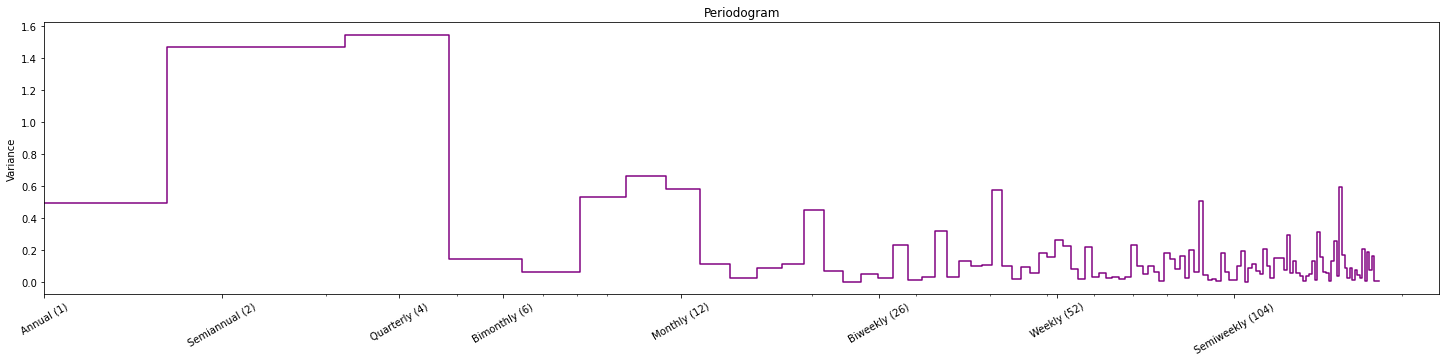

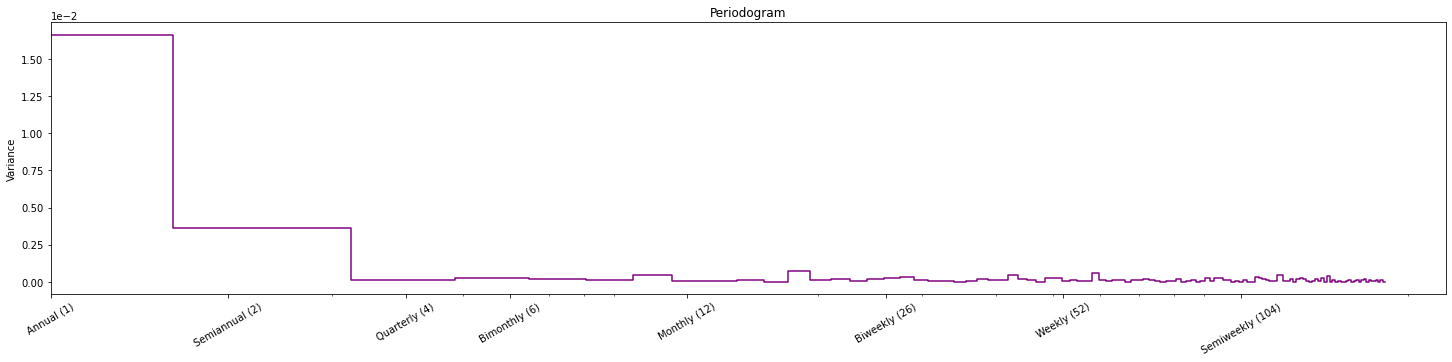

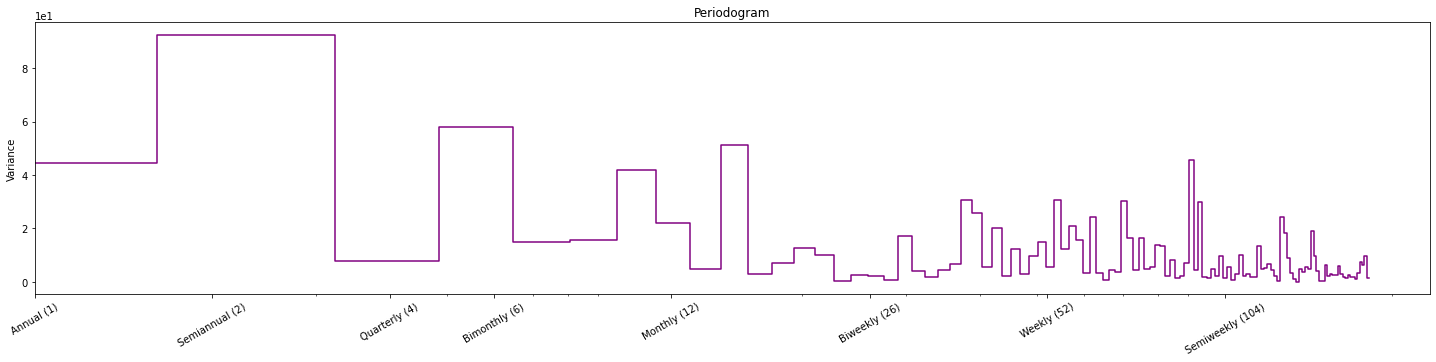

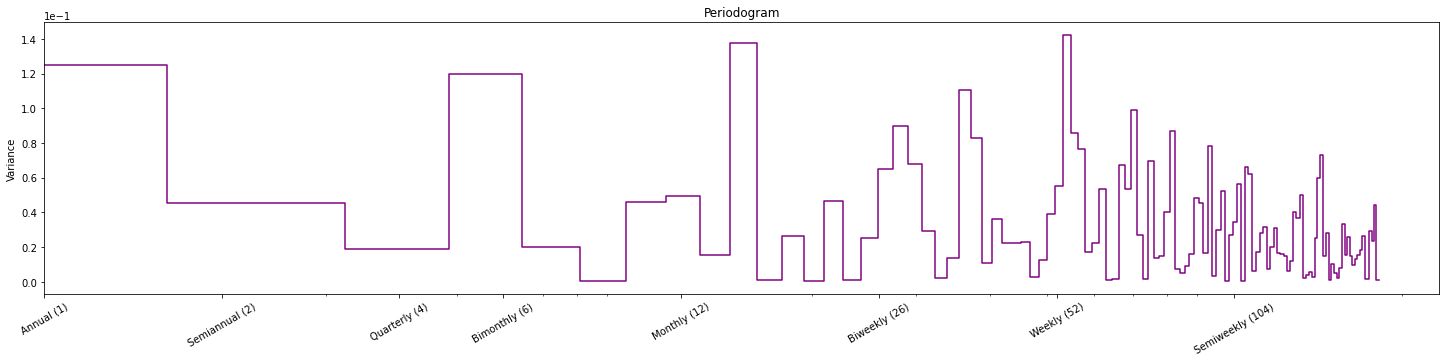

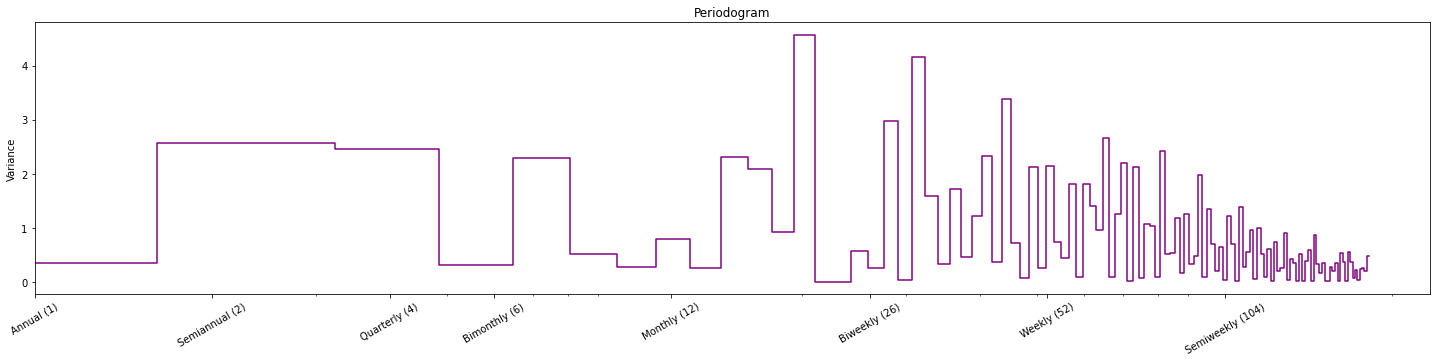

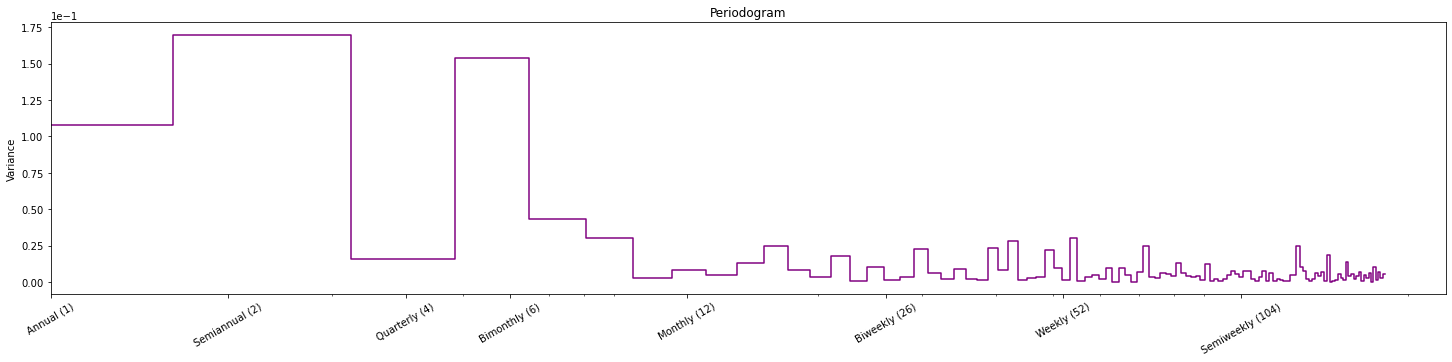

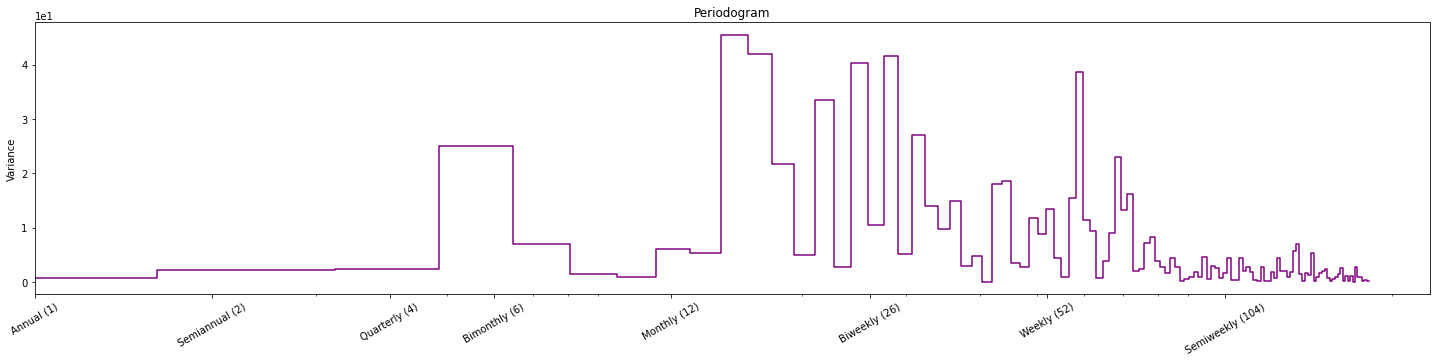

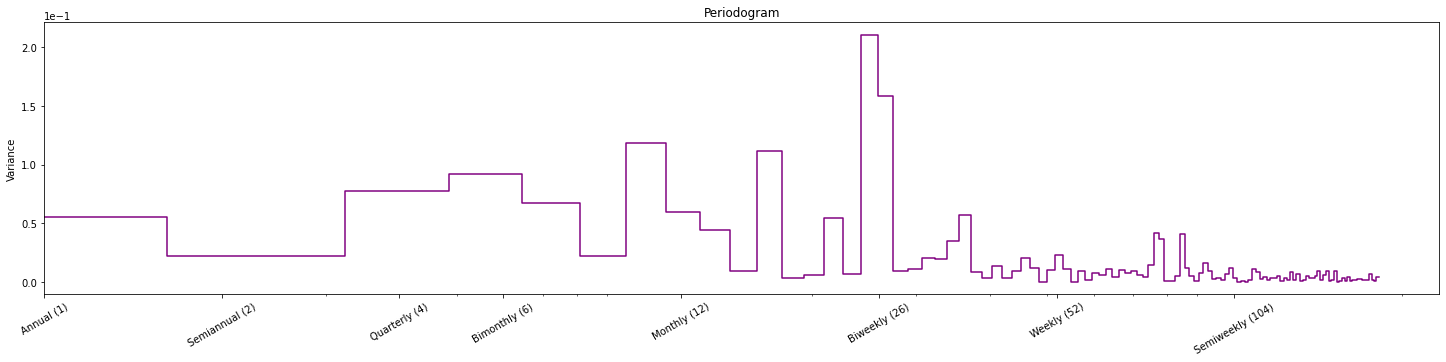

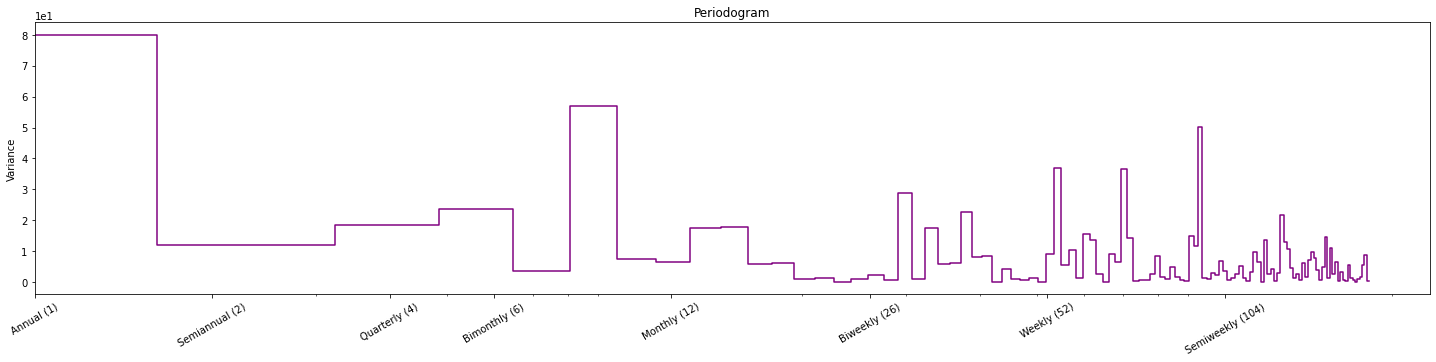

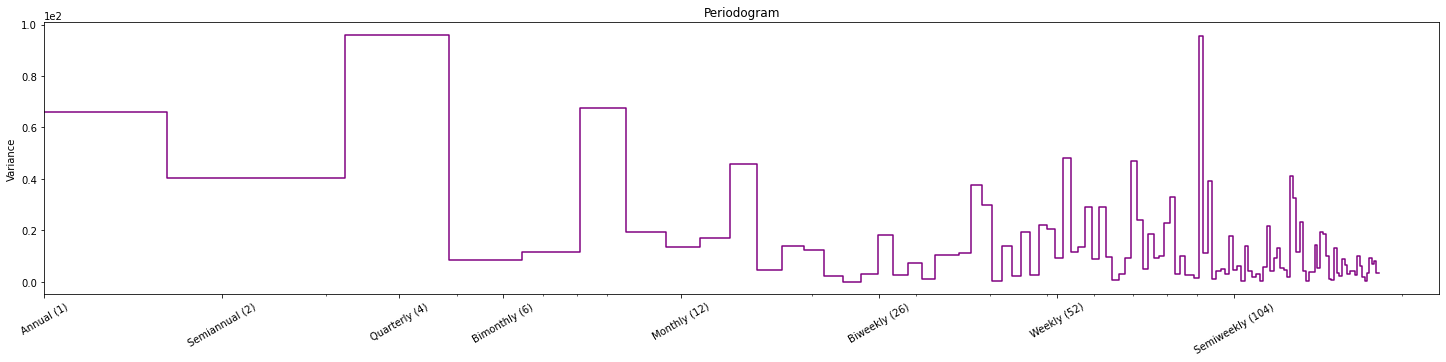

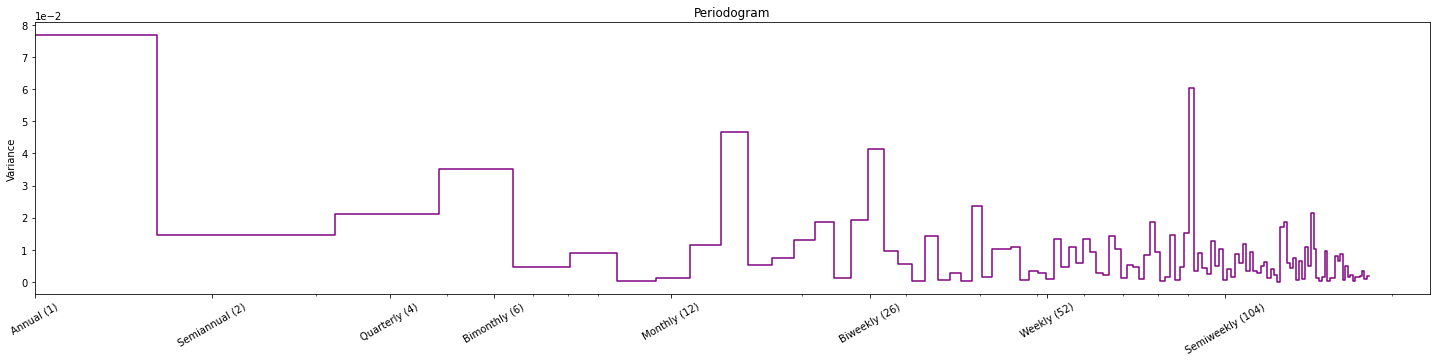

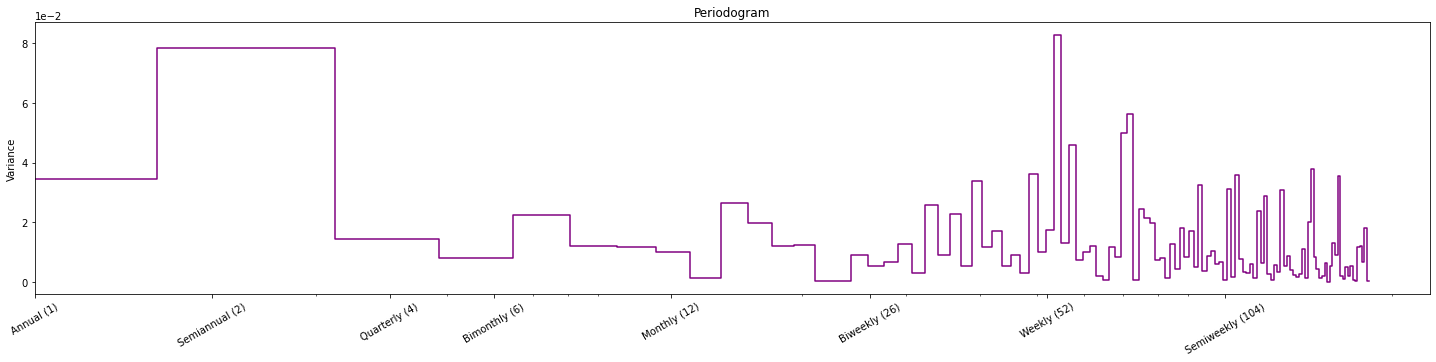

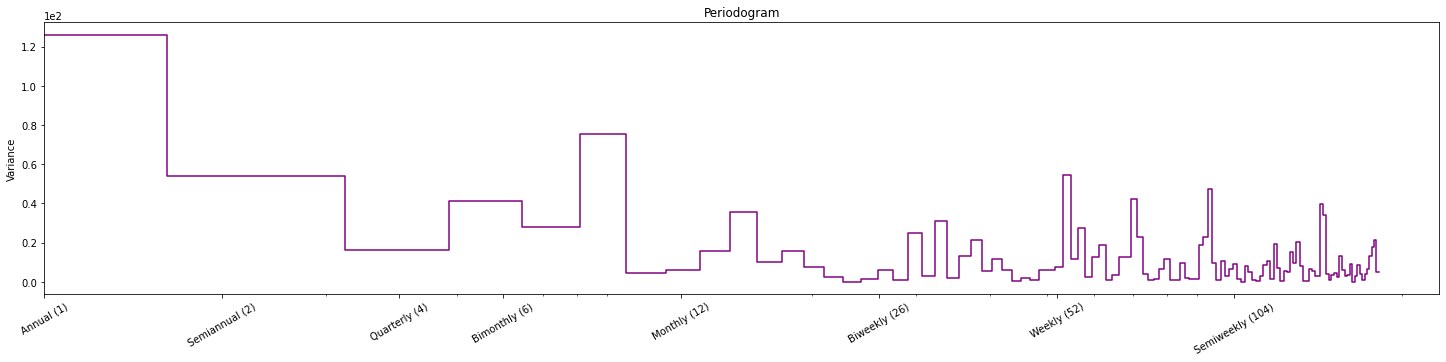

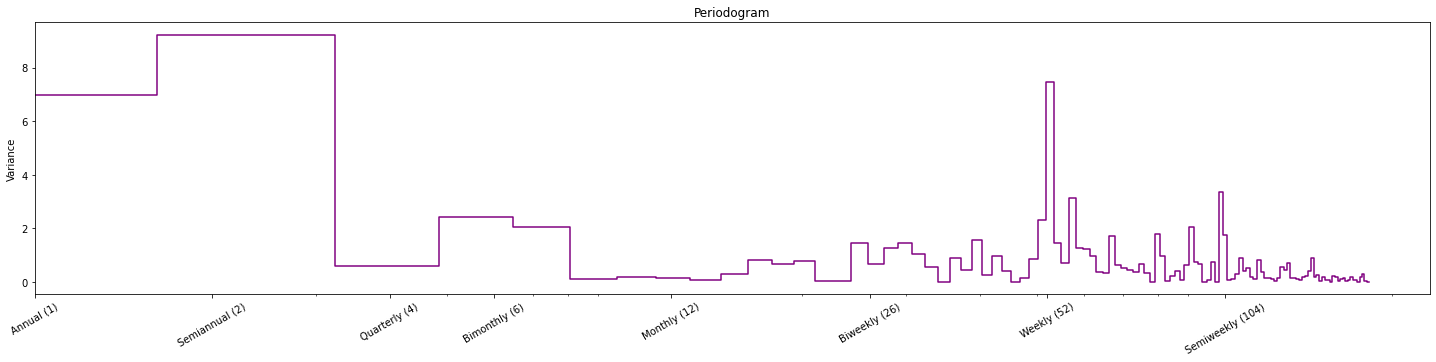

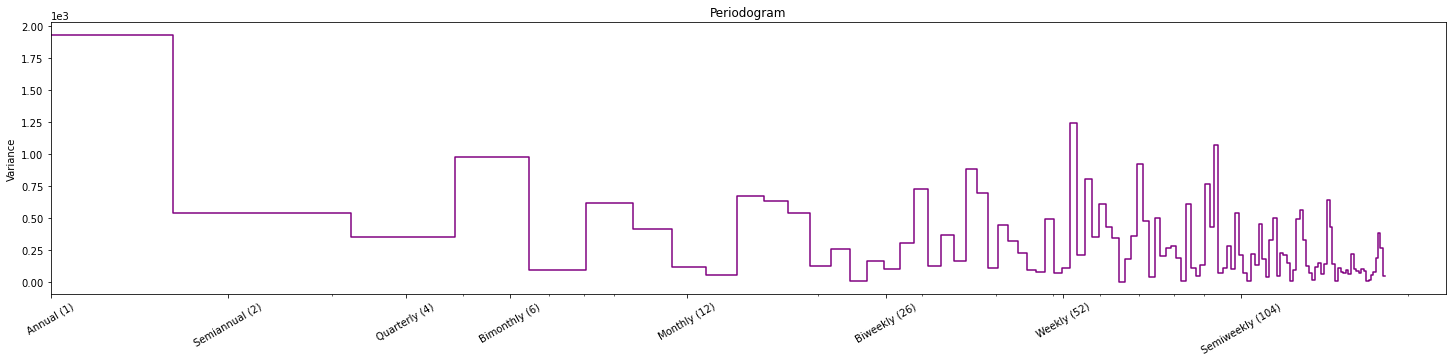

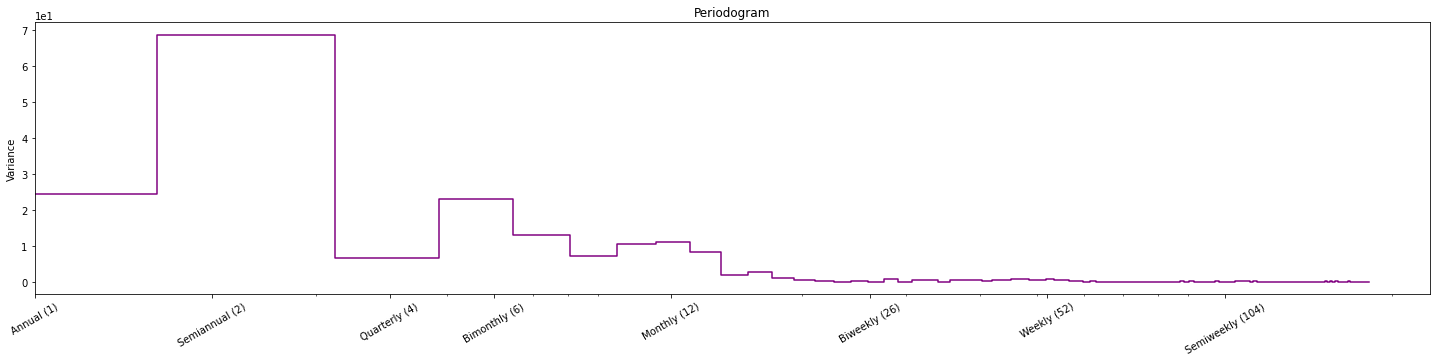

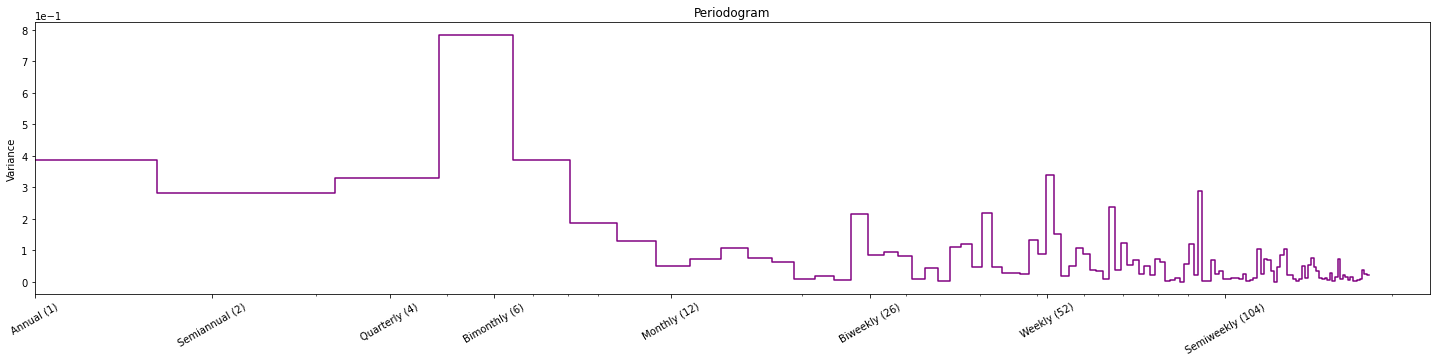

In [33]:
Total_residuos = (residuos_LR_train.groupby(['family','date']).mean().squeeze())
for familia in familias:
    plot_periodogram(Total_residuos.loc[[familia], 'residuos'])

En función de la familia temporalidades muy distintas. Se va a generar Deterministic Process con Transformaciones de Fourier para diferentes temporalidades.

In [32]:
fourierA = CalendarFourier(freq="A", order=5)
fourierM = CalendarFourier(freq="M", order=2)
fourierW = CalendarFourier(freq="W", order=4)

dp = DeterministicProcess(
    index = residuos_LR_train.index.unique(),
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourierA, fourierM, fourierW],
    drop=True)

In [33]:
residuos_LR_train = residuos_LR_train.join(dp.in_sample())
residuos_LR_train

,store_nbr,family,residuos,onpromotion,type_D,type_B,type_C,type_E,type_A,cluster,...,"sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","cos(3,freq=W-SUN)","sin(4,freq=W-SUN)"
date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,1,AUTOMOTIVE,3.323478,0,1,0,0,0,0,13,...,0.201299,0.979530,0.394356,0.918958,0.000000,1.00000,0.000000,1.000000,1.000000,0.000000
2017-01-02,1,BABY CARE,0.000000,0,1,0,0,0,0,13,...,0.201299,0.979530,0.394356,0.918958,0.000000,1.00000,0.000000,1.000000,1.000000,0.000000
2017-01-02,1,BEAUTY,-2.366353,0,1,0,0,0,0,13,...,0.201299,0.979530,0.394356,0.918958,0.000000,1.00000,0.000000,1.000000,1.000000,0.000000
2017-01-02,1,BEVERAGES,20.523578,31,1,0,0,0,0,13,...,0.201299,0.979530,0.394356,0.918958,0.000000,1.00000,0.000000,1.000000,1.000000,0.000000
2017-01-02,1,BOOKS,-0.267723,0,1,0,0,0,0,13,...,0.201299,0.979530,0.394356,0.918958,0.000000,1.00000,0.000000,1.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-15,54,POULTRY,-12.166820,0,0,0,1,0,0,3,...,0.299363,-0.954139,-0.571268,0.820763,0.781831,0.62349,0.974928,-0.222521,-0.900969,-0.433884
2017-08-15,54,PREPARED FOODS,3.989036,0,0,0,1,0,0,3,...,0.299363,-0.954139,-0.571268,0.820763,0.781831,0.62349,0.974928,-0.222521,-0.900969,-0.433884
2017-08-15,54,PRODUCE,-24.258599,76,0,0,1,0,0,3,...,0.299363,-0.954139,-0.571268,0.820763,0.781831,0.62349,0.974928,-0.222521,-0.900969,-0.433884


In [34]:
dp_test = dp.out_of_sample(steps=16)
residuos_LR_test = residuos_LR_test.join(dp_test)
residuos_LR_test

,onpromotion,store_nbr,family,type_D,type_B,type_C,type_E,type_A,cluster,Free_day,...,"sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","cos(3,freq=W-SUN)","sin(4,freq=W-SUN)"
2017-08-16,0,1,AUTOMOTIVE,1,0,0,0,0,13,0.0,...,0.101168,-0.994869,-0.201299,0.979530,0.974928,-0.222521,-0.433884,-0.900969,0.623490,0.781831
2017-08-16,0,1,BABY CARE,1,0,0,0,0,13,0.0,...,0.101168,-0.994869,-0.201299,0.979530,0.974928,-0.222521,-0.433884,-0.900969,0.623490,0.781831
2017-08-16,2,1,BEAUTY,1,0,0,0,0,13,0.0,...,0.101168,-0.994869,-0.201299,0.979530,0.974928,-0.222521,-0.433884,-0.900969,0.623490,0.781831
2017-08-16,20,1,BEVERAGES,1,0,0,0,0,13,0.0,...,0.101168,-0.994869,-0.201299,0.979530,0.974928,-0.222521,-0.433884,-0.900969,0.623490,0.781831
2017-08-16,0,1,BOOKS,1,0,0,0,0,13,0.0,...,0.101168,-0.994869,-0.201299,0.979530,0.974928,-0.222521,-0.433884,-0.900969,0.623490,0.781831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,1,9,POULTRY,0,1,0,0,0,6,0.0,...,-0.201299,0.979530,-0.394356,0.918958,0.433884,-0.900969,-0.781831,0.623490,-0.222521,-0.974928
2017-08-31,0,9,PREPARED FOODS,0,1,0,0,0,6,0.0,...,-0.201299,0.979530,-0.394356,0.918958,0.433884,-0.900969,-0.781831,0.623490,-0.222521,-0.974928
2017-08-31,1,9,PRODUCE,0,1,0,0,0,6,0.0,...,-0.201299,0.979530,-0.394356,0.918958,0.433884,-0.900969,-0.781831,0.623490,-0.222521,-0.974928
2017-08-31,9,9,SCHOOL AND OFFICE SUPPLIES,0,1,0,0,0,6,0.0,...,-0.201299,0.979530,-0.394356,0.918958,0.433884,-0.900969,-0.781831,0.623490,-0.222521,-0.974928


In [37]:
def make_lags_precio(ts, lags):
    return pd.concat(
        {
            f'y_lag_precio_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

oil['date'] = pd.to_datetime(oil['date'])
oil['date'] = oil.date.dt.to_period('D')
oil.set_index('date', inplace=True)
oil = oil.rename(columns={'dcoilwtico':'precio'})
#Se rellenan los nulos correspondientes al fin de semana con el valor del viernes
oil['precio'].ffill(inplace=True)
lags_oil = make_lags_precio(oil['precio'],4)
oil = oil.join(lags_oil)
oil['precio_medio_semanal'] = oil['precio'].rolling(7).mean()
oil = oil.loc['2017-01-01':,:]

In [44]:
residuos_LR = pd.concat([residuos_LR_train,residuos_LR_test])
residuos_LR.index.names = ['date']
residuos_LR = residuos_LR.join(oil)
residuos_LR['precio'].ffill(inplace=True)
residuos_LR['y_lag_precio_1'].ffill(inplace=True)
residuos_LR['y_lag_precio_2'].ffill(inplace=True)
residuos_LR['y_lag_precio_3'].ffill(inplace=True)
residuos_LR['y_lag_precio_4'].ffill(inplace=True)
residuos_LR['precio_medio_semanal'].ffill(inplace=True)

In [45]:
residuos_LR.isna().sum()

store_nbr                   0
family                      0
residuos                28512
onpromotion                 0
type_D                      0
type_B                      0
type_C                      0
type_E                      0
type_A                      0
cluster                     0
Free_day                    0
dayofweek                   0
dayofmonth                  0
const                       0
trend                       0
sin(1,freq=A-DEC)           0
cos(1,freq=A-DEC)           0
sin(2,freq=A-DEC)           0
cos(2,freq=A-DEC)           0
sin(3,freq=A-DEC)           0
cos(3,freq=A-DEC)           0
sin(4,freq=A-DEC)           0
cos(4,freq=A-DEC)           0
sin(5,freq=A-DEC)           0
cos(5,freq=A-DEC)           0
sin(1,freq=M)               0
cos(1,freq=M)               0
sin(2,freq=M)               0
cos(2,freq=M)               0
sin(1,freq=W-SUN)           0
cos(1,freq=W-SUN)           0
sin(2,freq=W-SUN)           0
cos(2,freq=W-SUN)           0
cos(3,freq

Se implementan también los meses de comienzo escolar

In [46]:
residuos_LR['Total_store_promotions'] = residuos_LR.groupby(by=['date', 'store_nbr']).onpromotion.transform(lambda x: x.sum())
residuos_LR['quarter'] = residuos_LR.index.quarter.astype('int')
residuos_LR = pd.get_dummies(residuos_LR, columns=['quarter'], drop_first=True)
residuos_LR['month'] = residuos_LR.index.month.astype('int')
residuos_LR['day'] = residuos_LR.index.day.astype('int')
residuos_LR['dayofweek'] = residuos_LR.index.day_of_week.astype('int')
residuos_LR['weekofyear'] = residuos_LR.index.week.astype('int')
residuos_LR['isweekend'] = residuos_LR.dayofweek.apply(lambda x: 1 if x in (5,6) else 0)
residuos_LR['startschool'] = residuos_LR.month.apply(lambda x: 1 if x in (4,5,8,9) else 0)
residuos_LR.drop('month', axis=1, inplace = True)

In [53]:
residuos_LR

,store_nbr,family,residuos,onpromotion,type_D,type_B,type_C,type_E,type_A,cluster,...,y_lag_precio_3,y_lag_precio_4,precio_medio_semanal,Total_store_promotions,quarter_2,quarter_3,day,weekofyear,isweekend,startschool
date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,1,AUTOMOTIVE,3.323478,0,1,0,0,0,0,13,...,54.01,52.82,53.164286,128,0,0,2,1,0,0
2017-01-02,1,BABY CARE,0.000000,0,1,0,0,0,0,13,...,54.01,52.82,53.164286,128,0,0,2,1,0,0
2017-01-02,1,BEAUTY,-2.366353,0,1,0,0,0,0,13,...,54.01,52.82,53.164286,128,0,0,2,1,0,0
2017-01-02,1,BEVERAGES,20.523578,31,1,0,0,0,0,13,...,54.01,52.82,53.164286,128,0,0,2,1,0,0
2017-01-02,1,BOOKS,-0.267723,0,1,0,0,0,0,13,...,54.01,52.82,53.164286,128,0,0,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,9,POULTRY,NaN,1,0,1,0,0,0,6,...,46.40,47.65,47.060000,223,0,1,31,35,0,1
2017-08-31,9,PREPARED FOODS,NaN,0,0,1,0,0,0,6,...,46.40,47.65,47.060000,223,0,1,31,35,0,1
2017-08-31,9,PRODUCE,NaN,1,0,1,0,0,0,6,...,46.40,47.65,47.060000,223,0,1,31,35,0,1


In [29]:
def make_lags_residuos(ts, lags):
    return pd.concat(
        {
            f'y_lag_residuos_{i}': ts.shift(i)
            for i in lags
        },
        axis=1)

def make_lags_promotions(ts, lags):
    return pd.concat(
        {
            f'y_lag_promotions_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

def make_leads_promotions(ts, leads):
    return pd.concat(
        {
            f'y_lead_promotions_{i}': ts.shift(-i)
            for i in range(1, leads + 1)
        },
        axis=1)

**Primero se va a intentar hacer un modelo sin considerar lags**

In [66]:
residuos_dict = {}

for familia in familias:
    residuos_dict[familia] = pd.DataFrame(residuos_LR[residuos_LR['family']==familia])
    residuos_dict[familia]['tienda'] = residuos_dict[familia]['store_nbr']
    residuos_dict[familia] = residuos_dict[familia].drop('family', axis=1)
    residuos_dict[familia] = residuos_dict[familia].reset_index().set_index(['store_nbr', 'date']).sort_index()

lags_promo_dict = {}
leads_promo_dict = {}
for familia in familias:
    lags_promo_dict[familia]=make_lags_promotions(residuos_dict[familia].onpromotion, lags = 3)
    leads_promo_dict[familia]=make_leads_promotions(residuos_dict[familia].onpromotion, leads = 3)
    residuos_dict[familia] = residuos_dict[familia].join(lags_promo_dict[familia])
    residuos_dict[familia] = residuos_dict[familia].join(leads_promo_dict[familia])

In [114]:
lista_tiendas = []
for i in range(1,55):
    lista_tiendas.append(i)

In [115]:
residuos_train_dict = {}
residuos_test_dict = {}

for familia in familias:
    residuos_train_dict[familia] = residuos_dict[familia].loc[(range(1,55),pd.period_range('2017-01-02', '2017-08-15')),:]
    residuos_test_dict[familia] = residuos_dict[familia].loc[(range(1,55),pd.period_range('2017-08-16', '2017-08-31')),:]
    residuos_train_dict[familia].loc[(lista_tiendas,'2017-01-02'),'y_lag_promotions_1':'y_lag_promotions_3'] = 0
    residuos_train_dict[familia].loc[(lista_tiendas,'2017-01-03'),'y_lag_promotions_2':'y_lag_promotions_3'] = 0
    residuos_train_dict[familia].loc[(lista_tiendas,'2017-01-04'),'y_lag_promotions_3'] = 0
    residuos_test_dict[familia].loc[(lista_tiendas,'2017-08-31'),'y_lead_promotions_1':'y_lead_promotions_3'] = 0
    residuos_test_dict[familia].loc[(lista_tiendas,'2017-08-30'),'y_lead_promotions_2':'y_lead_promotions_3'] = 0
    residuos_test_dict[familia].loc[(lista_tiendas,'2017-08-29'),'y_lead_promotions_3'] = 0

In [127]:
X_train_dict = {}
y_train_dict ={}
X_test_dict = {}

for familia in familias:
    X_train_dict[familia] = residuos_train_dict[familia].drop('residuos',axis=1)
    y_train_dict[familia] = pd.DataFrame(residuos_train_dict[familia]['residuos'])
    X_test_dict[familia] = residuos_test_dict[familia].drop('residuos',axis=1)

In [128]:
dict_params = {"n_estimators": [50, 100, 150],
               "max_depth": [5, 8, 11],
               "learning_rate": [0.05, 0.01, 0.1],
               "objective": ["reg:squarederror"],
               "tree_method": ["hist"],
               "subsample": [0.6,1]
              }

In [129]:
modelos_dict_XGB1 = {}
y_pred_dict_XGB1 = {}

for familia in familias:
    modelos_dict_XGB1[familia] = GridSearchCV(estimator=XGBRegressor(random_state=50),
                         param_grid=dict_params,
                         refit=True,
                         verbose=1,
                         n_jobs=-1,
                         return_train_score=True,
                         scoring="neg_mean_squared_error"
                         )

In [130]:
for familia in familias:
    modelos_dict_XGB1[familia].fit(X_train_dict[familia], y_train_dict[familia])
    print(f'Ajustado modelo de {familia} \n {modelos_dict_XGB1[familia].best_params_}')
    y_pred_dict_XGB1[familia] =pd.DataFrame(modelos_dict_XGB1[familia].predict(X_train_dict[familia]), index=y_train_dict[familia].index, columns=y_train_dict[familia].columns)
    print(f'El error cuadrático medio de {familia} en train es {mean_squared_error(y_train_dict[familia], y_pred_dict_XGB1[familia])}')

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Ajustado modelo de AUTOMOTIVE 
 {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 150, 'objective': 'reg:squarederror', 'subsample': 0.6, 'tree_method': 'hist'}
El error cuadrático medio de AUTOMOTIVE en train es 12.46483089514658
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Ajustado modelo de BABY CARE 
 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 50, 'objective': 'reg:squarederror', 'subsample': 1, 'tree_method': 'hist'}
El error cuadrático medio de BABY CARE en train es 0.3161902052097986
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Ajustado modelo de BEAUTY 
 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.6, 'tree_method': 'hist'}
El error cuadrático medio de BEAUTY en train es 6.936220978845403
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Ajustado modelo de BEVERAGES 
 {'learning_rate': 0.05

Ajustado modelo de POULTRY 
 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 1, 'tree_method': 'hist'}
El error cuadrático medio de POULTRY en train es 3419.8943478498823
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Ajustado modelo de PREPARED FOODS 
 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 50, 'objective': 'reg:squarederror', 'subsample': 0.6, 'tree_method': 'hist'}
El error cuadrático medio de PREPARED FOODS en train es 479.86245748356794
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Ajustado modelo de PRODUCE 
 {'learning_rate': 0.01, 'max_depth': 11, 'n_estimators': 150, 'objective': 'reg:squarederror', 'subsample': 0.6, 'tree_method': 'hist'}
El error cuadrático medio de PRODUCE en train es 70965.07417039185
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Ajustado modelo de SCHOOL AND OFFICE SUPPLIES 
 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 

Predicciones de test

In [135]:
y_fore_dict_XGB1 = {}
for familia in familias:
    y_fore_dict_XGB1[familia] =pd.DataFrame(modelos_dict_XGB1[familia].predict(X_test_dict[familia]), index=X_test_dict[familia].index, columns=y_train_dict[familia].columns)

In [137]:
residuos_ajustados_test = pd.DataFrame()
for familia in familias:
    y_fore_dict_XGB1[familia]['family']=familia
    residuos_ajustados_test = pd.concat([residuos_ajustados_test, y_fore_dict_XGB1[familia]])

In [138]:
residuos_ajustados_test = residuos_ajustados_test.reset_index().set_index(['store_nbr', 'family', 'date']).sort_index().rename(columns={0:'predicted_residuos'})
y_fore_LR = y_fore_LR.stack(['store_nbr','family']).reset_index().set_index(['store_nbr', 'family', 'date']).sort_index().rename(columns={0:'predicted_sales'})
y_test_pred = pd.DataFrame()
y_test_pred['adjusted_predicted_sales'] = y_fore_LR['predicted_sales'] + residuos_ajustados_test['residuos']
y_test_pred.loc[y_test_pred['adjusted_predicted_sales']<0,'adjusted_predicted_sales'] = 0
y_test_pred

adjusted_predicted_sales
store_nbr family     date                                
1         AUTOMOTIVE 2017-08-16                  4.429764
                     2017-08-17                  4.178756
                     2017-08-18                  5.432726
                     2017-08-19                  4.390911
                     2017-08-20                  1.818184
...                                                   ...
54        SEAFOOD    2017-08-27                  2.210756
                     2017-08-28                  1.946070
                     2017-08-29                  2.997099
                     2017-08-30                  3.775956
                     2017-08-31                  2.883950

[28512 rows x 1 columns]

In [139]:
store_sales_test = store_sales_test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [140]:
y_submit = y_test_pred.join(store_sales_test.id)
y_submit.columns = ['sales','id']
y_submit = y_submit.set_index('id')
y_submit.sort_index(inplace=True)
y_submit

,sales
id,
3000888,4.429764
3000889,0.000000
3000890,5.387430
3000891,2598.889916
3000892,0.600716
...,...
3029395,350.558931
3029396,109.323429
3029397,1246.536555


In [141]:
y_submit.to_csv('submission12.csv')

**El RMSLE obtenido es de 0.53003, por lo que mejora claramente el ajuste de los residuos, si bien, no mejora al modelo en el que no se consideraban**

**Mismo modelo, pero teniendo en cuenta lag features para los residuos**

In [142]:
residuos_dict = {}

for familia in familias:
    residuos_dict[familia] = pd.DataFrame(residuos_LR[residuos_LR['family']==familia])
    residuos_dict[familia]['tienda'] = residuos_dict[familia]['store_nbr']
    residuos_dict[familia] = residuos_dict[familia].drop('family', axis=1)
    residuos_dict[familia] = residuos_dict[familia].reset_index().set_index(['store_nbr', 'date']).sort_index()

lags_promo_dict = {}
leads_promo_dict = {}
for familia in familias:
    lags_promo_dict[familia]=make_lags_promotions(residuos_dict[familia].onpromotion, lags = 3)
    leads_promo_dict[familia]=make_leads_promotions(residuos_dict[familia].onpromotion, leads = 3)
    residuos_dict[familia] = residuos_dict[familia].join(lags_promo_dict[familia])
    residuos_dict[familia] = residuos_dict[familia].join(leads_promo_dict[familia])

In [143]:
lags_resi_dict = {}
for familia in imp_lags.keys():
    lags_resi_dict[familia]=make_lags_residuos(residuos_dict[familia].residuos, lags = imp_lags[familia])
    residuos_dict[familia] = residuos_dict[familia].join(lags_resi_dict[familia])

Se eliminan las fechas para las que los lags son desconocidos

In [145]:
residuos_train_dict = {}
residuos_test_dict = {}

for familia in familias:
    residuos_train_dict[familia] = residuos_dict[familia].loc[(range(1,55),pd.period_range('2017-01-09', '2017-08-15')),:]
    residuos_test_dict[familia] = residuos_dict[familia].loc[(range(1,55),pd.period_range('2017-08-16', '2017-08-31')),:]
    residuos_test_dict[familia].loc[(lista_tiendas,'2017-08-31'),'y_lead_promotions_1':'y_lead_promotions_3'] = 0
    residuos_test_dict[familia].loc[(lista_tiendas,'2017-08-30'),'y_lead_promotions_2':'y_lead_promotions_3'] = 0
    residuos_test_dict[familia].loc[(lista_tiendas,'2017-08-29'),'y_lead_promotions_3'] = 0

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [148]:
X_train_dict = {}
y_train_dict ={}

for familia in familias:
    X_train_dict[familia] = residuos_train_dict[familia].drop('residuos',axis=1)
    y_train_dict[familia] = pd.DataFrame(residuos_train_dict[familia]['residuos'])

In [150]:
dict_params = {"n_estimators": [50, 100, 150, 200],
               "max_depth": [5, 8, 11, 14],
               "learning_rate": [0.05, 0.01, 0.1],
               "objective": ["reg:squarederror"],
               "tree_method": ["hist"],
               "subsample": [0.6,1]}

In [151]:
modelos_dict_XGB2 = {}
y_pred_dict_XGB2 = {}

for familia in familias:
    modelos_dict_XGB2[familia] = GridSearchCV(estimator=XGBRegressor(random_state=50),
                         param_grid=dict_params,
                         refit=True,
                         verbose=1,
                         n_jobs=-1,
                         return_train_score=True,
                         scoring="neg_mean_squared_error"
                         )

In [152]:
for familia in familias:
    modelos_dict_XGB2[familia].fit(X_train_dict[familia], y_train_dict[familia])
    print(f'Ajustado modelo de {familia} \n {modelos_dict_XGB2[familia].best_params_}')
    y_pred_dict_XGB2[familia] =pd.DataFrame(modelos_dict_XGB2[familia].predict(X_train_dict[familia]), index=y_train_dict[familia].index, columns=y_train_dict[familia].columns)
    print(f'El error cuadrático medio de {familia} en train es {mean_squared_error(y_train_dict[familia], y_pred_dict_XGB2[familia])}')

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Ajustado modelo de AUTOMOTIVE 
 {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.6, 'tree_method': 'hist'}
El error cuadrático medio de AUTOMOTIVE en train es 11.989337569812164
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Ajustado modelo de BABY CARE 
 {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.6, 'tree_method': 'hist'}
El error cuadrático medio de BABY CARE en train es 0.28733839279523204
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Ajustado modelo de BEAUTY 
 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.6, 'tree_method': 'hist'}
El error cuadrático medio de BEAUTY en train es 6.2670969101608405
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Ajustado modelo de BEVERAGES 
 {'learning_rate'

Ajustado modelo de POULTRY 
 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.6, 'tree_method': 'hist'}
El error cuadrático medio de POULTRY en train es 2745.258165113647
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Ajustado modelo de PREPARED FOODS 
 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'objective': 'reg:squarederror', 'subsample': 0.6, 'tree_method': 'hist'}
El error cuadrático medio de PREPARED FOODS en train es 400.70136426696547
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Ajustado modelo de PRODUCE 
 {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 1, 'tree_method': 'hist'}
El error cuadrático medio de PRODUCE en train es 40051.147268479916
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Ajustado modelo de SCHOOL AND OFFICE SUPPLIES 
 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 

In [153]:
X1_test_dict = {}
resul_actual = {}

for familia in familias:
    X1_test_dict[familia] = residuos_test_dict[familia].loc[:,'onpromotion':'y_lead_promotions_3']
    X1_test_dict[familia] = X1_test_dict[familia].reset_index()
    resul_actual[familia] = pd.concat([y_train_dict[familia].reset_index(),X1_test_dict[familia].reset_index()[['date','store_nbr']]]).set_index(['store_nbr','date']).sort_index()

In [158]:
fechas = pd.date_range(start="2017-08-16", end = "2017-08-31").to_period(freq='D').tolist()
lags_resi_test={}
X2_iteracion = {}
X1_iteracion = {}
X_iteracion = {}
pred_iter = {}

for fecha in fechas:
    for familia in familias:
        X1_iteracion[familia] = X1_test_dict[familia][X1_test_dict[familia]['date']==fecha]
        X1_iteracion[familia] = X1_iteracion[familia].set_index(['store_nbr','date']).sort_index()
        if familia in imp_lags.keys():
            lags_resi_test[familia] = make_lags_residuos(resul_actual[familia].residuos, lags = imp_lags[familia])
            lags_resi_test[familia].reset_index(inplace=True)
            X2_iteracion[familia] = lags_resi_test[familia][lags_resi_test[familia]['date']==fecha]
            X2_iteracion[familia] = X2_iteracion[familia].set_index(['store_nbr','date']).sort_index()
            X_iteracion[familia] = X1_iteracion[familia].join(X2_iteracion[familia])
        else:
            X_iteracion[familia] = X1_iteracion[familia]
        pred_iter[familia] = pd.DataFrame(modelos_dict_XGB2[familia].predict(X_iteracion[familia]), index=X_iteracion[familia].index, columns = y_train_dict[familia].columns)
        resul_actual[familia] = resul_actual[familia].reset_index()
        resul_actual[familia] = resul_actual[familia][resul_actual[familia]['date'] != fecha]
        resul_actual[familia] = resul_actual[familia].set_index(['store_nbr', 'date']).sort_index()
        resul_actual[familia] = pd.concat([resul_actual[familia],pred_iter[familia]]).sort_index() 

In [159]:
y_fore_dict2 = {}

for familia in familias:
    y_fore_dict2[familia] = resul_actual[familia].reset_index()
    y_fore_dict2[familia] = y_fore_dict2[familia][y_fore_dict2[familia]['date']>='2017-08-16'].set_index(['store_nbr','date']).sort_index()

In [160]:
residuos_ajustados_test2 = pd.DataFrame()
for familia in familias:
    y_fore_dict2[familia]['family']=familia
    residuos_ajustados_test2 = pd.concat([residuos_ajustados_test2, y_fore_dict2[familia]])

In [161]:
residuos_ajustados_test2 = residuos_ajustados_test2.reset_index().set_index(['store_nbr', 'family', 'date']).sort_index().rename(columns={0:'predicted_residuos'})
y_test_pred2 = pd.DataFrame()
y_test_pred2['adjusted_predicted_sales'] = y_fore_LR['predicted_sales'] + residuos_ajustados_test2['residuos']
y_test_pred2.loc[y_test_pred2['adjusted_predicted_sales']<0,'adjusted_predicted_sales'] = 0
y_test_pred2

adjusted_predicted_sales
store_nbr family     date                                
1         AUTOMOTIVE 2017-08-16                  4.272111
                     2017-08-17                  4.128134
                     2017-08-18                  5.383420
                     2017-08-19                  4.338674
                     2017-08-20                  1.897128
...                                                   ...
54        SEAFOOD    2017-08-27                  2.717380
                     2017-08-28                  2.210864
                     2017-08-29                  3.127461
                     2017-08-30                  3.968657
                     2017-08-31                  3.170424

[28512 rows x 1 columns]

In [162]:
y_submit2 = y_test_pred2.join(store_sales_test.id)
y_submit2.columns = ['sales','id']
y_submit2 = y_submit2.set_index('id')
y_submit2.sort_index(inplace=True)
y_submit2

,sales
id,
3000888,4.272111
3000889,0.064329
3000890,6.623928
3000891,2409.696099
3000892,0.366931
...,...
3029395,350.860495
3029396,102.178879
3029397,1228.898208


In [164]:
y_submit2.to_csv('submission13.csv')

**El RMSLE obtenido es de 0.65269, por lo que claramente, al introducir los lags de los residuos, el modelo ha empeorado**